# NLP Sentiment Analysis: Apple and Google Products' Tweets

## *1. Introduction*

This project aims to perform sentiment analysis on tweets related to Apple and Google products using a labeled dataset. By classifying tweets as positive, negative, or neutral, we seek to understand public perception of these tech giants and uncover trends in user opinion. The dataset offers a realistic glimpse into consumer sentiment, making it ideal for training and evaluating NLP classification models.

### *Problem Statement*

With millions of users sharing their opinions on social media, understanding customer sentiment toward major tech brands is vital. This project seeks to automatically classify tweets mentioning Apple and Google products into positive, negative, or neutral sentiments. By leveraging natural language processing, we aim to build a model that can extract meaningful insights from public opinion, helping stakeholders understand brand perception and inform strategic decisions.

### *Dataset Overview: "tweet_product_company.csv"*

This dataset captures real-world tweet data mentioning Apple and Google products, offering a rich source of public sentiment expressed through social media. Each entry typically includes the tweet's text, the referenced product, the associated company (Apple or Google), and a sentiment label—categorized as **positive**, **negative**, or **neutral**.

### *Data Source*

The dataset was curated from Twitter via public scraping or aggregated repositories, specifically targeting mentions of Apple and Google. While exact sourcing details may vary, the collection aligns with ethical standards for public tweet analysis and is commonly used in NLP and sentiment modeling projects. It reflects organic user opinions and consumer reactions across various product releases, updates, and experiences.

### *Why This Dataset?*

This data is perfectly suited for sentiment analysis because:
- Tweets are short, noisy, and opinion-driven—ideal for testing robust NLP techniques.
- It supports both **binary** classification (positive vs negative) and **multiclass** sentiment prediction.
- Comparative sentiment between Apple and Google enables business insights and brand analysis.
- It offers real-world variability—emoji usage, slang, abbreviations—which makes preprocessing more meaningful.

Through this dataset, we aim to:
- Understand how users perceive Apple vs. Google across time.
- Build a scalable model that can automatically detect sentiment in real time.
- Extract actionable insights that can guide marketing, product improvements, and customer engagement.

## 2 Data Preparation

### 2.1 Data Loading

In [225]:
# Import basic libraries
import pandas as pd  
import numpy as np  
import seaborn as sns
import matplotlib.pyplot as plt

# Import NLP tools and NLTK library modules
from collections import Counter
from wordcloud import WordCloud
import nltk 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer 
from nltk import pos_tag  
import string  
import re 

# Import scikit-learn library's classes, tools, and modules 
from sklearn.model_selection import train_test_split 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB 
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline  
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score 
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import FunctionTransformer, LabelEncoder  

# Import tensorflow, and keras modules
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

# Disable warnings
import warnings
warnings.filterwarnings('ignore')

- Load the `tweet_product_company.csv` dataset

In [2]:
# Load the dataset from CSV file
df = pd.read_csv('/home/trigger/Documents/Flatiron/phase4/project/NLP-models-for-twitter-sentiment-analysis--google-and-apple-products-/data/tweet_product_company.csv', encoding='Latin-1')  

- Inspect fist five columns

In [3]:
# Print first 5 rows
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


- Inspect columns 

In [4]:
# Print column attributes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


### 2.2 Data Cleaning

- Check duplicates

In [5]:
df.duplicated().sum()

np.int64(22)

- Drop duplicates

In [6]:
df = df.drop_duplicates()

In [7]:
# Confirm no duplicate entries
df.duplicated().sum()

np.int64(0)

- Rename Columns for Clarity

In [8]:
# Rename columns 
df = df.rename(columns={
    'tweet_text': 'tweet',  # Rename tweet text column
    'emotion_in_tweet_is_directed_at': 'product',  # Rename product column
    'is_there_an_emotion_directed_at_a_brand_or_product': 'sentiment'  # Rename sentiment column
})

In [9]:
# Recheck columns' attributes
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9071 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      9070 non-null   object
 1   product    3282 non-null   object
 2   sentiment  9071 non-null   object
dtypes: object(3)
memory usage: 283.5+ KB


- It is evident the `products` column has many missing values.
- Inspect unique values for the `products` column

In [10]:
df['product'].value_counts()

product
iPad                               945
Apple                              659
iPad or iPhone App                 469
Google                             428
iPhone                             296
Other Google product or service    293
Android App                         80
Android                             77
Other Apple product or service      35
Name: count, dtype: int64

Define a function **_categorize_product_** that takes the parameter `tweet` from **_df_**.
- Check if the input `tweet` is null or missing (If **_true_**; return **unknown**).
- If **_false_**; convert the string for each entry for the column `tweet` to lowercase to ensure case-insensitive matching.
- If the string for the column `tweet` contains the words: **_'iphone', 'ipad', or 'apple'_**; return **Apple**.
- If the string for the column `tweet` contains the words: **_'google', or 'android'_**; return **Google**.
- If none of these conditions are met return **unknown**.

In [11]:
# Define a function to categorize products
def categorize_product(tweet):
    if pd.isnull(tweet):
        return 'unknown'
    tweet = tweet.lower()
    if 'iphone' in tweet or 'ipad' in tweet or 'apple' in tweet:
        return 'Apple'
    elif 'google' in tweet or 'android' in tweet:
        return 'Google'
    else:
        return 'unknown'

# Apply the function to the 'tweet' column and fill the 'product' column
df['product'] = df['tweet'].apply(categorize_product)

# Verify the changes
df['product'].value_counts()


product
Apple      5520
Google     2766
unknown     785
Name: count, dtype: int64

- Handle Missing Values

In [12]:
# Srop entries with the value `unknown' for the `product` column
df = df[df['product'] != 'unknown']

In [13]:
# Drop rows with missing values in 'tweet' or 'sentiment' columns
df = df.dropna(subset=['tweet', 'sentiment']) 

In [14]:
# Remove rows where sentiment is 'I can't tell'
df = df[df['sentiment'] != "I can't tell"] 

In [15]:
# Reset index after dropping rows
df = df.reset_index(drop=True)  

In [16]:
# Re-inspect column attributes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8136 entries, 0 to 8135
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      8136 non-null   object
 1   product    8136 non-null   object
 2   sentiment  8136 non-null   object
dtypes: object(3)
memory usage: 190.8+ KB


In [17]:
# Rename Sentiments
df.loc[:, 'sentiment'] = df['sentiment'].replace({
    'No emotion toward brand or product': 'Neutral',
    'Positive emotion': 'Positive',
    'Negative emotion': 'Negative'})

In [18]:
# Verify changes
df['sentiment'].value_counts()

sentiment
Neutral     4636
Positive    2932
Negative     568
Name: count, dtype: int64

## 3 Data Preprocessing  

### 3.1 Define helper functions for preprocessing

- Text cleaning

In [201]:
# Define function to remove URLs, mentions, hashtags, punctuation, and lowercase
def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
   # text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.lower()
    return text

- Stopword removal

In [202]:
# Define function to remove stopwords from text
def remove_stopwords(text):
    stop_words = stopwords.words('english')
    pronouns = {'i', 'me', 'my', 'mine', 'myself', 'you', 'your', 'yours', 'yourself',
                'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself',
                'it', 'its', 'itself', 'we', 'us', 'our', 'ours', 'ourselves',
                'they', 'them', 'their', 'theirs', 'themselves'}
    stop_words += pronouns
    tokens = word_tokenize(text)
    return ' '.join([word for word in tokens if word not in stop_words])

- Lemmatization

In [203]:
# Define function to lemmatize each word in the text
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    return ' '.join([lemmatizer.lemmatize(word) for word in tokens])

- Stemming

In [204]:
# Define function to Stem each word in the text
def stem_text(text):
    stemmer = PorterStemmer()
    tokens = word_tokenize(text)
    return ' '.join([stemmer.stem(word) for word in tokens])

- POS Tagging

In [23]:
# Define function to lemmatize using POS tagging
# To use Neural Network
def pos_lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    def get_wordnet_pos(tag):
        if tag.startswith('J'):
            return 'a'
        elif tag.startswith('V'):
            return 'v'
        elif tag.startswith('N'):
            return 'n'
        elif tag.startswith('R'):
            return 'r'
        else:
            return 'n'
    return ' '.join([lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags])

In [205]:
# Define function to stem using POS tagging
def pos_stem_text(text):
    stemmer = PorterStemmer()
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    return ' '.join([stemmer.stem(word) for word, _ in pos_tags])

- Tokenization

In [206]:
# Define function to tokenize using TweetTokenizer
def tweet_tokenize_text(text):
    tokenizer = TweetTokenizer()
    return ' '.join(tokenizer.tokenize(text))

In [207]:
# Define function to tokenize using word_tokenize
def word_tokenize_text(text):
    return word_tokenize(text)

### 3.2 Extrapolatory Data Analysis

In [27]:
# create a copy of df
df_clean = df.copy()

In [28]:
df_clean['clean_tweet'] = df_clean['tweet'].apply(clean_text)
df_clean.head()

,tweet,product,sentiment,clean_tweet
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Apple,Negative,i have a 3g iphone after 3 hrs tweeting at i...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Apple,Positive,know about awesome ipadiphone app that youl...
2,@swonderlin Can not wait for #iPad 2 also. The...,Apple,Positive,can not wait for 2 also they should sale the...
3,@sxsw I hope this year's festival isn't as cra...,Apple,Negative,i hope this years festival isnt as crashy as ...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive,great stuff on fri marissa mayer google tim ...


In [29]:
df_clean['stopwords_removed'] = df_clean['clean_tweet'].apply(remove_stopwords)
df_clean.head()

,tweet,product,sentiment,clean_tweet,stopwords_removed
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Apple,Negative,i have a 3g iphone after 3 hrs tweeting at i...,3g iphone 3 hrs tweeting dead need upgrade plu...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Apple,Positive,know about awesome ipadiphone app that youl...,know awesome ipadiphone app youll likely appre...
2,@swonderlin Can not wait for #iPad 2 also. The...,Apple,Positive,can not wait for 2 also they should sale the...,wait 2 also sale
3,@sxsw I hope this year's festival isn't as cra...,Apple,Negative,i hope this years festival isnt as crashy as ...,hope years festival isnt crashy years iphone app
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive,great stuff on fri marissa mayer google tim ...,great stuff fri marissa mayer google tim oreil...


In [30]:
df_clean['tokenized_tweet'] = df_clean['stopwords_removed'].apply(word_tokenize_text)
df_clean.head()

,tweet,product,sentiment,clean_tweet,stopwords_removed,tokenized_tweet
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Apple,Negative,i have a 3g iphone after 3 hrs tweeting at i...,3g iphone 3 hrs tweeting dead need upgrade plu...,"[3g, iphone, 3, hrs, tweeting, dead, need, upg..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Apple,Positive,know about awesome ipadiphone app that youl...,know awesome ipadiphone app youll likely appre...,"[know, awesome, ipadiphone, app, youll, likely..."
2,@swonderlin Can not wait for #iPad 2 also. The...,Apple,Positive,can not wait for 2 also they should sale the...,wait 2 also sale,"[wait, 2, also, sale]"
3,@sxsw I hope this year's festival isn't as cra...,Apple,Negative,i hope this years festival isnt as crashy as ...,hope years festival isnt crashy years iphone app,"[hope, years, festival, isnt, crashy, years, i..."
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive,great stuff on fri marissa mayer google tim ...,great stuff fri marissa mayer google tim oreil...,"[great, stuff, fri, marissa, mayer, google, ti..."


In [31]:
df_clean[['product', 'sentiment', 'tokenized_tweet']].head()

,product,sentiment,tokenized_tweet
0,Apple,Negative,"[3g, iphone, 3, hrs, tweeting, dead, need, upg..."
1,Apple,Positive,"[know, awesome, ipadiphone, app, youll, likely..."
2,Apple,Positive,"[wait, 2, also, sale]"
3,Apple,Negative,"[hope, years, festival, isnt, crashy, years, i..."
4,Google,Positive,"[great, stuff, fri, marissa, mayer, google, ti..."


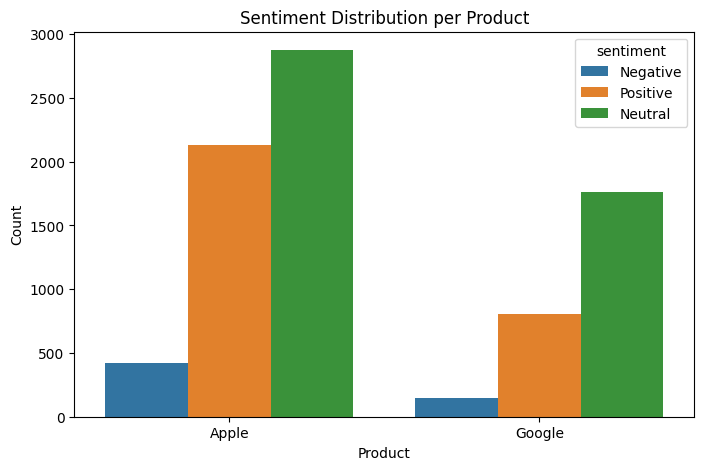

In [32]:
# Count plot of product vs sentiment
plt.figure(figsize=(8, 5))
sns.countplot(data=df_clean, x='product', hue='sentiment')
plt.title('Sentiment Distribution per Product')
plt.xlabel('Product')
plt.ylabel('Count')
plt.show()

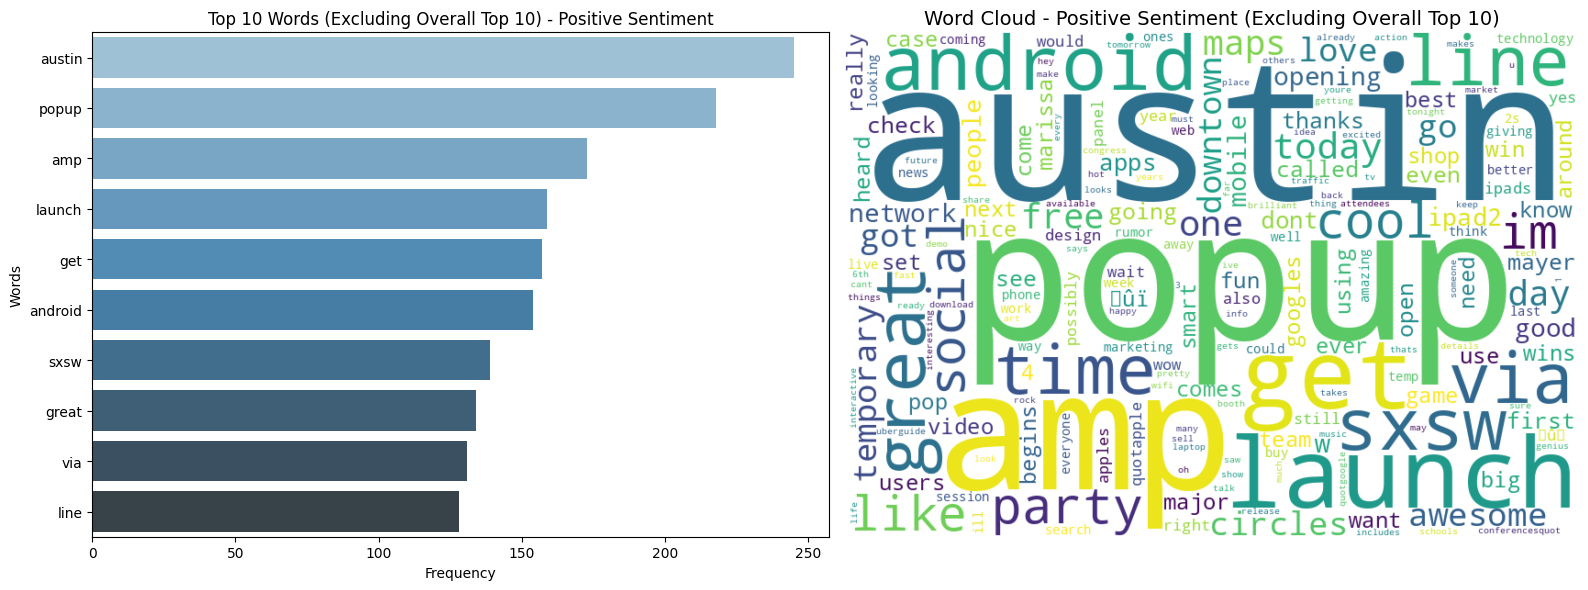

In [33]:
# Filter tokens for positive sentiment
positive_tokens = df_clean[df_clean['sentiment'] == 'Positive']['tokenized_tweet'].sum()
positive_freq = Counter(positive_tokens)
top_words = positive_freq.most_common(10)
words, counts = zip(*top_words)

# Determine top 10 words to exclude
top_10_words_to_exclude = positive_freq.most_common(10)
top_10_word_set = {word for word, count in top_10_words_to_exclude}

# Filter frequencies: exclude the top 10 most common words 
filtered_positive_freq = Counter()
for word, count in positive_freq.items():
    if word not in top_10_word_set:
        filtered_positive_freq[word] = count

top_words_for_barplot = filtered_positive_freq.most_common(10)
words_barplot, counts_barplot = zip(*top_words_for_barplot)

# Set up 1x2 plt.subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Barplot on LHS (uses filtered data)
if words_barplot: # Check if there are words to plot after filtering
    sns.barplot(ax=axes[0], x=list(counts_barplot), y=list(words_barplot), palette='Blues_d')
    axes[0].set_title("Top 10 Words (Excluding Overall Top 10) - Positive Sentiment")
    axes[0].set_xlabel("Frequency")
    axes[0].set_ylabel("Words")
else:
    axes[0].set_title("No words to plot for barplot after exclusion", fontsize=12)
    axes[0].axis('off')


# Word cloud on RHS (uses filtered data)
if filtered_positive_freq: # Check if there are words left for the word cloud
    wordcloud = WordCloud(width=800, height=550, background_color='white').generate_from_frequencies(filtered_positive_freq)
    axes[1].imshow(wordcloud, interpolation='bilinear')
    axes[1].set_title("Word Cloud - Positive Sentiment (Excluding Overall Top 10)", fontsize=14)
    axes[1].axis('off')
else:
    axes[1].set_title("Word Cloud (No words after exclusion)", fontsize=14)
    axes[1].axis('off')

plt.tight_layout()
plt.show()

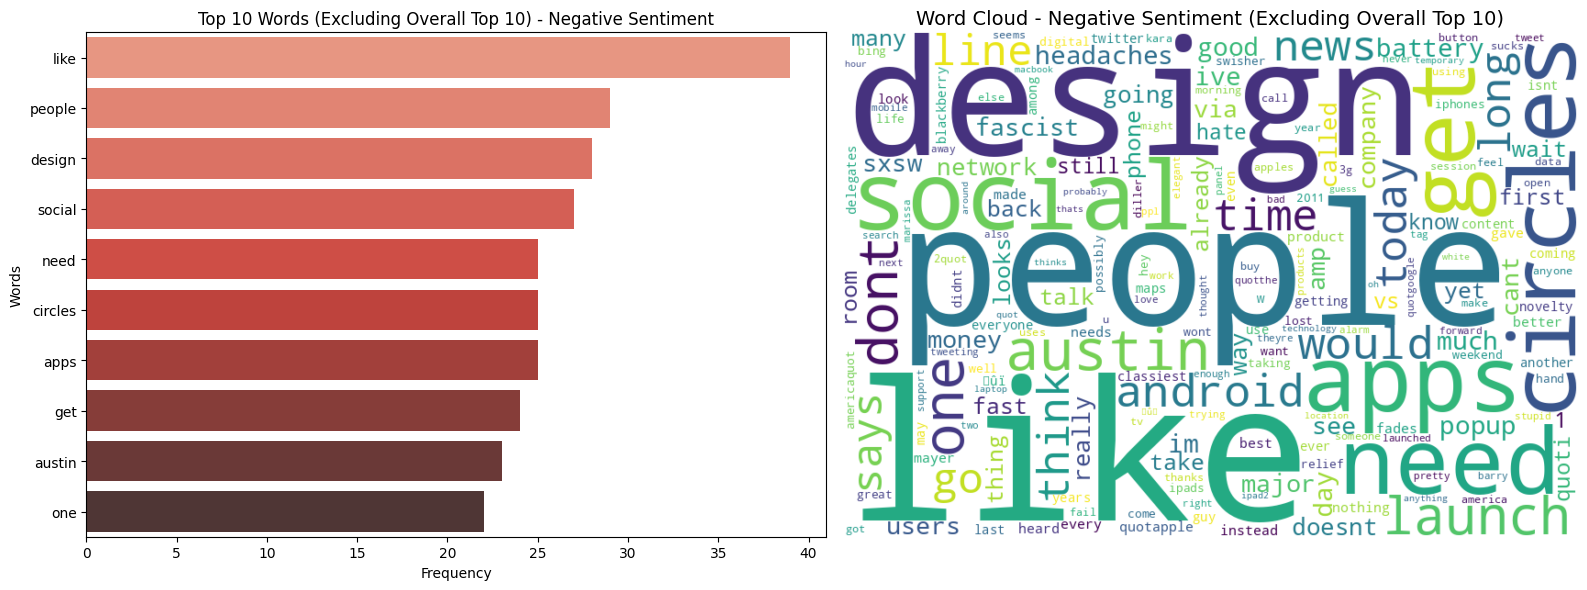

In [34]:
# Determine top 10 words to exclude
negative_tokens = df_clean[df_clean['sentiment'] == 'Negative']['tokenized_tweet'].sum()
negative_freq = Counter(negative_tokens) # This is the full frequency for all negative tokens

# Plot most common words excluding top ten most frequent
top_10_words_to_exclude = negative_freq.most_common(10) # Get top 10 from overall negative_freq
top_10_word_set = {word for word, count in top_10_words_to_exclude}

# Filter frequencies: exclude the top 10 most common words
filtered_negative_freq = Counter()
for word, count in negative_freq.items():
    if word not in top_10_word_set:
        filtered_negative_freq[word] = count

top_words_for_barplot = filtered_negative_freq.most_common(10) # Get top 10 from the filtered list
# Check if top_words_for_barplot is not empty before unpacking
if top_words_for_barplot:
    words_barplot, counts_barplot = zip(*top_words_for_barplot)
else:
    words_barplot, counts_barplot = [], [] # Assign empty lists if no words

# Set up 1x2 plt.subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Barplot
if words_barplot: # Check if there are words to plot after filtering
    sns.barplot(ax=axes[0], x=list(counts_barplot), y=list(words_barplot), palette='Reds_d')
    axes[0].set_title("Top 10 Words (Excluding Overall Top 10) - Negative Sentiment")
    axes[0].set_xlabel("Frequency")
    axes[0].set_ylabel("Words")
else:
    axes[0].set_title("No words to plot for barplot after exclusion", fontsize=12)
    axes[0].axis('off')


# Word cloud plot
if filtered_negative_freq: # Check if there are words left for the word cloud
    wordcloud = WordCloud(width=800, height=550, background_color='white').generate_from_frequencies(filtered_negative_freq)
    axes[1].imshow(wordcloud, interpolation='bilinear')
    axes[1].set_title("Word Cloud - Negative Sentiment (Excluding Overall Top 10)", fontsize=14)
    axes[1].axis('off')
else:
    axes[1].set_title("Word Cloud (No words after exclusion)", fontsize=14)
    axes[1].axis('off')

plt.tight_layout()
plt.show()

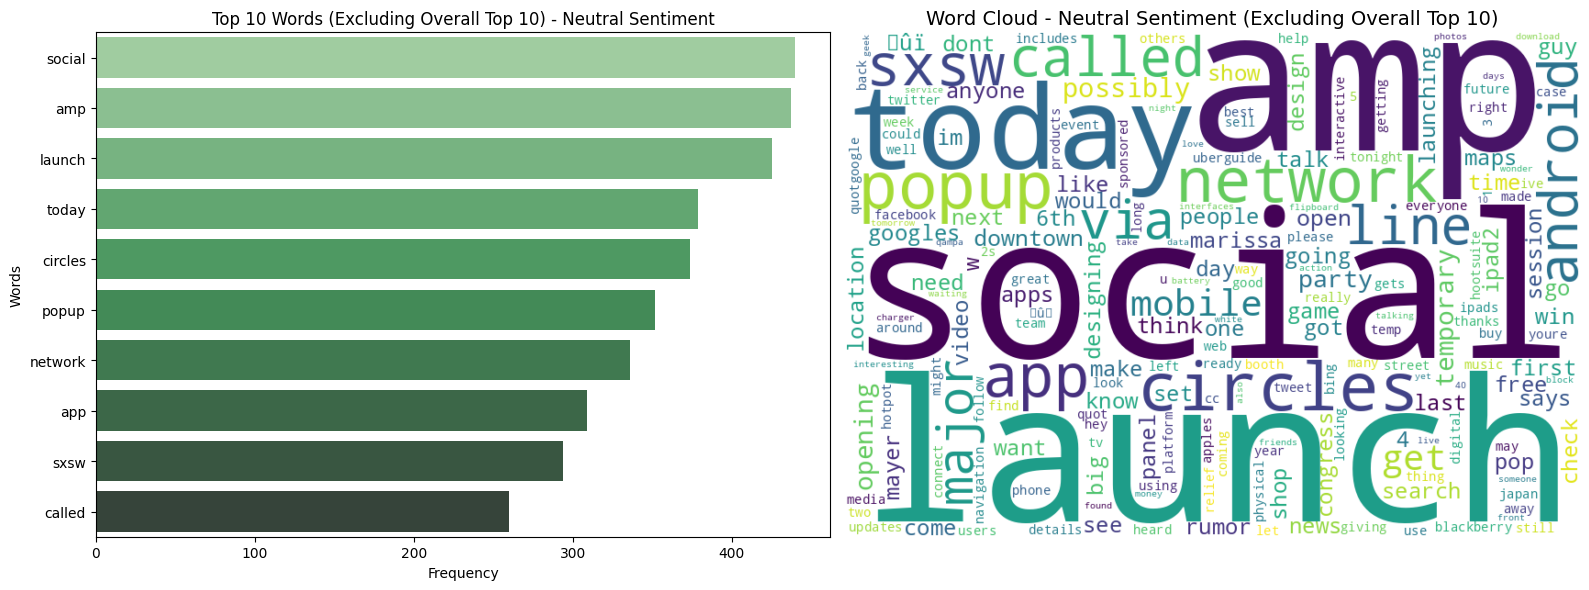

In [35]:
# Determine top 10 words to exclude
neutral_tokens = df_clean[df_clean['sentiment'] == 'Neutral']['tokenized_tweet'].sum()
neutral_freq = Counter(neutral_tokens) # This is the full frequency for all neutral tokens

# Plot most common words excluding top ten most frequent
top_10_words_to_exclude = neutral_freq.most_common(10) # Get top 10 from overall neutral_freq
top_10_word_set = {word for word, count in top_10_words_to_exclude}

# Filter frequencies: exclude the top 10 most common words
filtered_neutral_freq = Counter()
for word, count in neutral_freq.items():
    if word not in top_10_word_set:
        filtered_neutral_freq[word] = count

top_words_for_barplot = filtered_neutral_freq.most_common(10) # Get top 10 from the filtered list
# Check if top_words_for_barplot is not empty before unpacking
if top_words_for_barplot:
    words_barplot, counts_barplot = zip(*top_words_for_barplot)
else:
    words_barplot, counts_barplot = [], [] # Assign empty lists if no words

# Set up 1x2 plt.subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Barplot
if words_barplot: # Check if there are words to plot after filtering
    sns.barplot(ax=axes[0], x=list(counts_barplot), y=list(words_barplot), palette='Greens_d')
    axes[0].set_title("Top 10 Words (Excluding Overall Top 10) - Neutral Sentiment")
    axes[0].set_xlabel("Frequency")
    axes[0].set_ylabel("Words")
else:
    axes[0].set_title("No words to plot for barplot after exclusion", fontsize=12)
    axes[0].axis('off')


# Word cloud plot
if filtered_neutral_freq: # Check if there are words left for the word cloud
    wordcloud = WordCloud(width=800, height=550, background_color='white').generate_from_frequencies(filtered_neutral_freq)
    axes[1].imshow(wordcloud, interpolation='bilinear')
    axes[1].set_title("Word Cloud - Neutral Sentiment (Excluding Overall Top 10)", fontsize=14)
    axes[1].axis('off')
else:
    axes[1].set_title("Word Cloud (No words after exclusion)", fontsize=14)
    axes[1].axis('off')

plt.tight_layout()
plt.show()

## 4 Modelling

### 4.1 Predicting Product 

- Build, a **Logistic Regression** model to predict `product` based on `tokenized_tweet` (**_from df_clean_**).

In [36]:
# Join tokenized_tweet words
df_clean["joined_tweet"] = df_clean["tokenized_tweet"].apply(lambda x: " ".join(x))

# Define Exog and Endog
X_product = df_clean["joined_tweet"]
y_product = df_clean["product"]

In [37]:
# Split data
'''First split: Training_full_product (80% of X) and Test_product (20% of X)'''
X_train_full_product, X_test_product, y_train_full_product, y_test_product = train_test_split(
    X_product, y_product, test_size=0.2, random_state=42, stratify=y_product)

'''Second split: Training (80% of X_train_full_product) and Validation (20% of X_train_full_product)'''
X_train_product, X_val_product, y_train_product, y_val_product = train_test_split(
    X_train_full_product, y_train_full_product, test_size=0.2, random_state=42, stratify=y_train_full_product)

In [38]:
# Print the sizes of each set
print(f"Training set size: {len(X_train_product)}")
print(f"Validation set size: {len(X_val_product)}")
print(f"Test set size: {len(X_test_product)}")

Training set size: 5206
Validation set size: 1302
Test set size: 1628


- Assemble pipeline for modelling a Logistic Regression model fitted with TF-IDF vectorized data

In [39]:
# Pipeline for TfidfVectorized features
pipeline_tfidf = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", LogisticRegression(max_iter=200))
])

# Fit and evaluate
pipeline_tfidf.fit(X_train_product, y_train_product)
y_pred_product_tfidf = pipeline_tfidf.predict(X_val_product)

print("TF-IDF Vectorizer Results:")
print(classification_report(y_val_product, y_pred_product_tfidf))
print(confusion_matrix(y_val_product, y_pred_product_tfidf))

TF-IDF Vectorizer Results:
              precision    recall  f1-score   support

       Apple       0.96      1.00      0.98       867
      Google       0.99      0.93      0.96       435

    accuracy                           0.97      1302
   macro avg       0.98      0.96      0.97      1302
weighted avg       0.97      0.97      0.97      1302

[[863   4]
 [ 32 403]]


In [40]:
# Pipeline for CountVectorized features
pipeline_count = Pipeline([
    ("count", CountVectorizer()),
    ("clf", LogisticRegression(max_iter=200))
])

# Fit and evaluate
pipeline_count.fit(X_train_product, y_train_product)
y_pred_product_tfidf = pipeline_count.predict(X_val_product)

print("Count Vectorizer Results:")
print(classification_report(y_val_product, y_pred_product_tfidf))
print(confusion_matrix(y_val_product, y_pred_product_tfidf))

Count Vectorizer Results:
              precision    recall  f1-score   support

       Apple       0.98      0.99      0.99       867
      Google       0.99      0.96      0.97       435

    accuracy                           0.98      1302
   macro avg       0.98      0.97      0.98      1302
weighted avg       0.98      0.98      0.98      1302

[[861   6]
 [ 19 416]]


- Select Logistic Regression model fitted with vectorized data using CountVectorization to perform Hyperparameter tuning.

In [41]:
# Hyperparameter tuning with GridSearchCV()
pipeline_count = Pipeline([
    ("count", CountVectorizer()),
    ("clf", LogisticRegression(max_iter=200))
])

# Hyperparameter grid
param_grid = {
    "clf__C": [0.01, 0.1, 1, 10],
    "clf__penalty": ["l2"],
    "clf__solver": ["liblinear", "saga"]
}

# Run grid search
grid_search_lr = GridSearchCV(pipeline_count, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_lr.fit(X_train_product, y_train_product)

# Best model and parameters
print("Best Parameters:", grid_search_lr.best_params_)
print("Best CV Score:", grid_search_lr.best_score_)


Best Parameters: {'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Best CV Score: 0.9721465960863706


In [137]:
# Define the model pipeline with best parameters
lr_pipeline = Pipeline([
    ("count", CountVectorizer()),
    ("clf", LogisticRegression(
        C=10,
        penalty="l2",
        solver="liblinear",
        max_iter=200,
        random_state=42
    ))
])

# Fit the model on full training data
lr_pipeline.fit(X_train_product, y_train_product)

# Evaluate on validation set
y_val_pred_product = lr_pipeline.predict(X_val_product)

# Evaluarte on test test
y_test_pred_product = grid_search_lr.predict(X_test_product)

# Performance Metrics
print("Classification Report (Validation set):")
print(classification_report(y_val_product, y_val_pred_product))
print("Confusion Matrix (Validation set):")
print(confusion_matrix(y_val_product, y_val_pred_product))
print("-------------------------------------------------------")
print("Classification Report (Test set):")
print(classification_report(y_test_product, y_test_pred_product))
print("Confusion Matrix (Test set):")
print(confusion_matrix(y_test_product, y_test_pred_product))

Classification Report (Validation set):
              precision    recall  f1-score   support

       Apple       0.99      0.99      0.99       867
      Google       0.97      0.97      0.97       435

    accuracy                           0.98      1302
   macro avg       0.98      0.98      0.98      1302
weighted avg       0.98      0.98      0.98      1302

Confusion Matrix (Validation set):
[[856  11]
 [ 12 423]]
-------------------------------------------------------
Classification Report (Test set):
              precision    recall  f1-score   support

       Apple       0.98      0.99      0.99      1085
      Google       0.97      0.97      0.97       543

    accuracy                           0.98      1628
   macro avg       0.98      0.98      0.98      1628
weighted avg       0.98      0.98      0.98      1628

Confusion Matrix (Test set):
[[1071   14]
 [  17  526]]


- Predict on test set.

In [211]:
# Save tuned LR model
import joblib
joblib.dump(lr_pipeline, "logistic_model.joblib")
print("Logistic Regression model for predicting `product` (Apple or Google) saved as 'logistic_model.joblib'")

Logistic Regression model for predicting `product` (Apple or Google) saved as 'logistic_model.joblib'


### 4.2 Prediciting Sentiment

### 4.2.1 Define Helper Functions

- Define function to compute a models' performance **_classification_matrix_** and **_confusion_matrix_**.

In [44]:
def classification_metrics(y_true, y_pred):
    print("Classification Report")
    print(classification_report(y_true, y_pred))
    print("Confusion Matrix")
    print(confusion_matrix(y_true, y_pred))          

Define function to compute **_Accuracy_**, **_Precision_**, **_Recall_**, and **_F1-score_** for models fitted with either of four uniquely preprocessed data alternatives based on: 
- Whether the data is **Lemmatized** or **Stemmed**.
- Whether the data is vectorized via the **_Bag-of-Words_** technique or **_TF-IDF_** framework.

Hence, each model is fitted on **_cleaned, stopwords removed_** data that is either:
1. **Lemmatized** and vectorized using the **CountVectorizer**.
2. **Lemmatized** and vectorized using the **TfidfVectorizer**.
3. **Stemmed** and vectorized using the **CountVectorizer**.
4. **Stemmed** and vectorized using the **TfidfVectorizer**.

- The metrics returned by the function facilitate identification of the model alternative for hyperparameter tuning using GridSearchCV.

In [45]:
def calculate_metrics(X_val, y_val, y_pred_lemma_bow, y_pred_lemma_tfidf, y_pred_stem_bow, y_pred_stem_tfidf,
                         lemma_bow, lemma_tfidf, stem_bow, stem_tfidf):
    # Calculate performance metrics for MNB
    metrics = {
        'Lemma BoW': {
            'Accuracy': lemma_bow.score(X_val, y_val),
            'Precision': precision_score(y_val, y_pred_lemma_bow, average='weighted'),
            'Recall': recall_score(y_val, y_pred_lemma_bow, average='weighted'),
            'F1-Score': f1_score(y_val, y_pred_lemma_bow, average='weighted')
        },
        'Lemma TF-IDF': {
            'Accuracy': lemma_tfidf.score(X_val, y_val),
            'Precision': precision_score(y_val, y_pred_lemma_tfidf, average='weighted'),
            'Recall': recall_score(y_val, y_pred_lemma_tfidf, average='weighted'),
            'F1-Score': f1_score(y_val, y_pred_lemma_tfidf, average='weighted')
        },
        'Stem BoW': {
            'Accuracy': stem_bow.score(X_val, y_val),
            'Precision': precision_score(y_val, y_pred_stem_bow, average='weighted'),
            'Recall': recall_score(y_val, y_pred_stem_bow, average='weighted'),
            'F1-Score': f1_score(y_val, y_pred_stem_bow, average='weighted')
        },
        'Stem TF-IDF': {
            'Accuracy': stem_tfidf.score(X_val, y_val),
            'Precision': precision_score(y_val, y_pred_stem_tfidf, average='weighted'),
            'Recall': recall_score(y_val, y_pred_stem_tfidf, average='weighted'),
            'F1-Score': f1_score(y_val, y_pred_stem_tfidf, average='weighted')
        }
    }
    # Create DataFrame
    df_metrics = pd.DataFrame(metrics).T
    return df_metrics

- Define function to compute **_Accuracy_**, **_Precision_**, **_Recall_**, and **_F1-score_** for models fitted with either of four uniquely preprocessed data alternatives and the Hyperparameter tuned classifier.

In [46]:
def calculate_metrics_compare(X_val, y_val, y_pred_lemma_bow, y_pred_lemma_tfidf, y_pred_stem_bow, y_pred_stem_tfidf, y_pred_tuned,
                         lemma_bow, lemma_tfidf, stem_bow, stem_tfidf, grid_search):
    # Calculate performance metrics alongside tuned model
    metrics_compare = {
        'Lemma BoW': {
            'Accuracy': lemma_bow.score(X_val, y_val),
            'Precision': precision_score(y_val, y_pred_lemma_bow, average='weighted'),
            'Recall': recall_score(y_val, y_pred_lemma_bow, average='weighted'),
            'F1-Score': f1_score(y_val, y_pred_lemma_bow, average='weighted')
        },
        'Lemma TF-IDF': {
            'Accuracy': lemma_tfidf.score(X_val, y_val),
            'Precision': precision_score(y_val, y_pred_lemma_tfidf, average='weighted'),
            'Recall': recall_score(y_val, y_pred_lemma_tfidf, average='weighted'),
            'F1-Score': f1_score(y_val, y_pred_lemma_tfidf, average='weighted')
        },
        'Stem BoW': {
            'Accuracy': stem_bow.score(X_val, y_val),
            'Precision': precision_score(y_val, y_pred_stem_bow, average='weighted'),
            'Recall': recall_score(y_val, y_pred_stem_bow, average='weighted'),
            'F1-Score': f1_score(y_val, y_pred_stem_bow, average='weighted')
        },
        'Stem TF-IDF': {
            'Accuracy': stem_tfidf.score(X_val, y_val),
            'Precision': precision_score(y_val, y_pred_stem_tfidf, average='weighted'),
            'Recall': recall_score(y_val, y_pred_stem_tfidf, average='weighted'),
            'F1-Score': f1_score(y_val, y_pred_stem_tfidf, average='weighted')
        },
        'Tuned Model': {
            'Accuracy': grid_search.score(X_val, y_val),
            'Precision': precision_score(y_val, y_pred_tuned, average='weighted'),
            'Recall': recall_score(y_val, y_pred_tuned, average='weighted'),
            'F1-Score': f1_score(y_val, y_pred_tuned, average='weighted')
        }
    }
    # Create DataFrame
    df_metrics_compare = pd.DataFrame(metrics_compare).T
    return df_metrics_compare

- Define function to plot a grouped bar-chart for computed performance metrics of each model alternative alongside the tuned classifier. 

In [47]:
def calculate_metrics_viz(X_val, y_val, y_pred_lemma_bow, y_pred_lemma_tfidf, y_pred_stem_bow, y_pred_stem_tfidf, y_pred_tuned,
                         lemma_bow, lemma_tfidf, stem_bow, stem_tfidf, grid_search):
  
       # Calculate performance metrics alongside tuned model
    metrics_compare = {
        'Lemma BoW': {
            'Accuracy': lemma_bow.score(X_val, y_val),
            'Precision': precision_score(y_val, y_pred_lemma_bow, average='weighted'),
            'Recall': recall_score(y_val, y_pred_lemma_bow, average='weighted'),
            'F1-Score': f1_score(y_val, y_pred_lemma_bow, average='weighted')
        },
        'Lemma TF-IDF': {
            'Accuracy': lemma_tfidf.score(X_val, y_val),
            'Precision': precision_score(y_val, y_pred_lemma_tfidf, average='weighted'),
            'Recall': recall_score(y_val, y_pred_lemma_tfidf, average='weighted'),
            'F1-Score': f1_score(y_val, y_pred_lemma_tfidf, average='weighted')
        },
        'Stem BoW': {
            'Accuracy': stem_bow.score(X_val, y_val),
            'Precision': precision_score(y_val, y_pred_stem_bow, average='weighted'),
            'Recall': recall_score(y_val, y_pred_stem_bow, average='weighted'),
            'F1-Score': f1_score(y_val, y_pred_stem_bow, average='weighted')
        },
        'Stem TF-IDF': {
            'Accuracy': stem_tfidf.score(X_val, y_val),
            'Precision': precision_score(y_val, y_pred_stem_tfidf, average='weighted'),
            'Recall': recall_score(y_val, y_pred_stem_tfidf, average='weighted'),
            'F1-Score': f1_score(y_val, y_pred_stem_tfidf, average='weighted')
        },
        'Tuned Model': {
            'Accuracy': grid_search.score(X_val, y_val),
            'Precision': precision_score(y_val, y_pred_tuned, average='weighted'),
            'Recall': recall_score(y_val, y_pred_tuned, average='weighted'),
            'F1-Score': f1_score(y_val, y_pred_tuned, average='weighted')
        }
    }
    # Data for plotting
    models = list(metrics_compare.keys())
    metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    values = np.array([[metrics_compare[model][metric] for metric in metrics_names] for model in models]).T

    # Calculate cumulative scores and sort models
    cumulative_scores = [sum(metrics_compare[model][metric] for metric in metrics_names) for model in models]
    sort_indices = np.argsort(cumulative_scores)[::-1]
    models = [models[i] for i in sort_indices]
    values = values[:, sort_indices]
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.15
    index = np.arange(len(models))

    for i, metric in enumerate(metrics_names):
        plt.bar(index + i * bar_width, values[i], bar_width, label=metric)

    plt.xlabel('Models')
    plt.ylabel('Scores')
    plt.title('Model Performance Comparison')
    plt.xticks(index + bar_width * 1.5, models, rotation=0)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.tight_layout()
    plt.show()

### 4.2.2 Train-Validation-Test Split

In [48]:
# Prepare features and labels for modeling
X = df['tweet']  # Features: tweet text
y = df['sentiment']  # Labels: sentiment category

In [49]:
# Stratified split for balanced classes (stratify=y)
'''First split: Training_full (80% of X) and Test (20% of X)'''
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y) 

In [50]:
# Stratified split for balanced classes (stratify=y_train_full)
'''Second split: Training (80% of X_train_full) and Validation (20% of X_train_full)'''
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.20, random_state=42, stratify=y_train_full)  

In [51]:
# Print the sizes of each set
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Training set size: 5206
Validation set size: 1302
Test set size: 1628


### 4.2.3 Multinomial Naves Bayes Classifier

- The Multinomial Naves Bayes classifier is the baseline model.
- Define pipelines for the untuned Multimodal Naves Bayes Classifier to determine the best performing alternative.
- The best performing alternative is selected for Hyper-parameter tuning using GridSearchCV, 

In [52]:
mnb_lemma_bow = Pipeline([
        ('clean', FunctionTransformer(lambda x: [clean_text(t) for t in x], validate=False)),  # Clean text
        ('stopwords', FunctionTransformer(lambda x: [remove_stopwords(t) for t in x], validate=False)),  # Remove stopwords
        ('lemmatize', FunctionTransformer(lambda x: [lemmatize_text(t) for t in x], validate=False)),  # Lemmatize
        ('vectorize', CountVectorizer()),  # BoW vectorization
        ('model', MultinomialNB()) 
    ])

In [53]:
mnb_lemma_tfidf = Pipeline([
        ('clean', FunctionTransformer(lambda x: [clean_text(t) for t in x], validate=False)),  # Clean text
        ('stopwords', FunctionTransformer(lambda x: [remove_stopwords(t) for t in x], validate=False)),  # Remove stopwords
        ('lemmatize', FunctionTransformer(lambda x: [lemmatize_text(t) for t in x], validate=False)),  # Lemmatize
        ('vectorize', TfidfVectorizer()),  # TF-IDF vectorization
        ('model', MultinomialNB()) 
    ])

In [54]:
mnb_stem_bow = Pipeline([
        ('clean', FunctionTransformer(lambda x: [clean_text(t) for t in x], validate=False)), # Clean text
        ('stopwords', FunctionTransformer(lambda x: [remove_stopwords(t) for t in x], validate=False)), # Remove stopwords
        ('stem', FunctionTransformer(lambda x: [stem_text(t) for t in x], validate=False)), # Stemmize
        ('vectorize', CountVectorizer()),# BoW vectorization
        ('model', MultinomialNB())  
    ])

In [55]:
mnb_stem_tfidf = Pipeline([
        ('clean', FunctionTransformer(lambda x: [clean_text(t) for t in x], validate=False)), # Clean text
        ('stopwords', FunctionTransformer(lambda x: [remove_stopwords(t) for t in x], validate=False)), # Remove stopwords
        ('stem', FunctionTransformer(lambda x: [stem_text(t) for t in x], validate=False)), # Stemmize
        ('vectorize', TfidfVectorizer()),# TF-IDF vectorization
        ('model', MultinomialNB())  
    ])

In [56]:
# Fit Vanilla MNB models on training set
mnb_lemma_bow.fit(X_train, y_train)
mnb_lemma_tfidf.fit(X_train, y_train)
mnb_stem_bow.fit(X_train, y_train)
mnb_stem_tfidf.fit(X_train, y_train)

# Predict labels for validation set
y_pred_lemma_bow = mnb_lemma_bow.predict(X_val)
y_pred_lemma_tfidf = mnb_lemma_tfidf.predict(X_val)
y_pred_stem_bow = mnb_stem_bow.predict(X_val)
y_pred_stem_tfidf = mnb_stem_tfidf.predict(X_val)

In [57]:
calculate_metrics(X_val, y_val, y_pred_lemma_bow, y_pred_lemma_tfidf, y_pred_stem_bow, y_pred_stem_tfidf,
                  mnb_lemma_bow, mnb_lemma_tfidf, mnb_stem_bow, mnb_stem_tfidf)

,Accuracy,Precision,Recall,F1-Score
Lemma BoW,0.639017,0.633870,0.639017,0.623308
Lemma TF-IDF,0.646697,0.680610,0.646697,0.592262
Stem BoW,0.655146,0.646639,0.655146,0.639883
Stem TF-IDF,0.645161,0.678742,0.645161,0.591023


Given the imbalanced nature of the dataset, **Stem BoW** is the best candidate for hyperparameter tuning because it achieves the highest F1-Score (0.6399) and recall (0.6555), which are crucial for capturing all sentiment classes effectively. Its higher recall suggests it is better at identifying instances across all classes, including the minority ones, which is important for sentiment analysis where missing a sentiment (e.g., a rare Negative tweet) could be significant.

- Hence, the vanilla **Multinomial Naves Bayes Classifier** fitted with **_Stemmed_** data that is vectorized via the **_Bag-of-Words_** technique (**mnb_stem_bow**) is selected for Hyper-parameter tuning.
- The scoring parameter for GridSearchCV is set to **'f1_weighted'** to prioritize improving the model's ability to classify all sentiments accurately, especially the minority classes.

In [58]:
# Hyperparameter tuning for mnb_stem_bow using GridSearchCV
from sklearn.model_selection import GridSearchCV

# Define named functions for FunctionTransformer (must be top-level for pickling)
def clean_texts(texts):
    return [clean_text(t) for t in texts]
def remove_stopwords_texts(texts):
    return [remove_stopwords(t) for t in texts]
def stem_texts(texts):
    return [stem_text(t) for t in texts]

# Define the pipeline (same as mnb_stem_bow, but with named functions)
mnb_stem_bow_pipeline = Pipeline([
    ('clean', FunctionTransformer(clean_texts, validate=False)),
    ('stopwords', FunctionTransformer(remove_stopwords_texts, validate=False)),
    ('stem', FunctionTransformer(stem_texts, validate=False)),
    ('vectorize_mnb', CountVectorizer()),
    ('model', MultinomialNB())
])

# Define parameter grid for alpha
param_grid = {
    'model__alpha': [0.1, 0.5, 1.0, 1.2, 1.5, 2.0],
    'vectorize_mnb__max_features': [2000, 5000, 10000], 
    'vectorize_mnb__ngram_range': [(1, 1), (1, 2), (1, 3)] 
}

grid_search = GridSearchCV(mnb_stem_bow_pipeline, param_grid, cv=5, scoring='f1_weighted', n_jobs=1)
grid_search.fit(X_train, y_train)

print("Best alpha:", grid_search.best_params_)
print("Best cross-validated accuracy:", grid_search.best_score_)


Best alpha: {'model__alpha': 0.5, 'vectorize_mnb__max_features': 5000, 'vectorize_mnb__ngram_range': (1, 1)}
Best cross-validated accuracy: 0.6290333445481536


In [59]:
# Print classification report and confusion matrix of selected vanilla model for tuning
classification_metrics(y_val, y_pred_stem_bow)

Classification Report
              precision    recall  f1-score   support

    Negative       0.59      0.18      0.27        91
     Neutral       0.69      0.80      0.74       742
    Positive       0.59      0.52      0.56       469

    accuracy                           0.66      1302
   macro avg       0.62      0.50      0.52      1302
weighted avg       0.65      0.66      0.64      1302

Confusion Matrix
[[ 16  48  27]
 [ 10 591 141]
 [  1 222 246]]


In [60]:
# Print classification report and confusion matrix of tuned model
y_pred_mnb_tuned = grid_search.predict(X_val)
classification_metrics(y_val, y_pred_mnb_tuned)

Classification Report
              precision    recall  f1-score   support

    Negative       0.47      0.31      0.37        91
     Neutral       0.70      0.74      0.72       742
    Positive       0.57      0.54      0.55       469

    accuracy                           0.64      1302
   macro avg       0.58      0.53      0.55      1302
weighted avg       0.63      0.64      0.64      1302

Confusion Matrix
[[ 28  37  26]
 [ 22 551 169]
 [ 10 204 255]]


- The tuned MNB classifier performs better in predicting **True Positives** for the minority class (**_28_**) compared to (**_16_**) for the untuned model.

In [61]:
# Compute accuracy, precision, recall, and f1-score
df_metrics_compare_mnb = calculate_metrics_compare(X_val, y_val, y_pred_lemma_bow, y_pred_lemma_tfidf, y_pred_stem_bow, y_pred_stem_tfidf,
                     y_pred_mnb_tuned, mnb_lemma_bow, mnb_lemma_tfidf, mnb_stem_bow, mnb_stem_tfidf, grid_search)

# Slice the DataFrame to include the selected vanilla model and the tuned classifier
df_filtered_mnb = df_metrics_compare_mnb.loc[['Stem BoW', 'Tuned Model']]

# Display the filtered results
df_filtered_mnb

,Accuracy,Precision,Recall,F1-Score
Stem BoW,0.655146,0.646639,0.655146,0.639883
Tuned Model,0.635223,0.633217,0.640553,0.635223


- The hyperparameter tuning of the Multinomial Naive Bayes (MNB) model did not yield an improvement in validation accuracy because the baseline model was already well-calibrated for the dataset, and the available hyperparameters (such as `alpha`) may not significantly impact performance given the nature of the text data and feature representation. 

- Additionally, setting the scoring parameter to **_f1-weighted_** during GridSearchCV prioritized improving prediction across all classes resulting to a hyperparameter tuned classifier whose accuracy was lower compared to the selected vanilla model for tuning which was probably performing well on the majority classes but poorly on the minority class.  

- Regardless, MNB makes strong independence assumptions between features, which may limit its ability to capture complex relationships in the data.

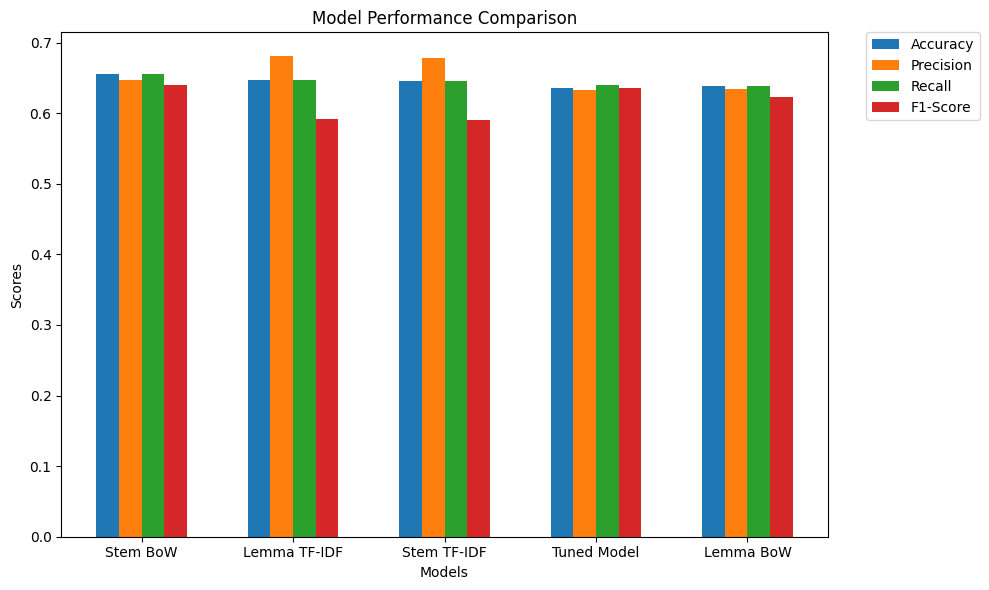

In [62]:
# Plot grouped barchart for performance metrics
calculate_metrics_viz(X_val, y_val, y_pred_lemma_bow, y_pred_lemma_tfidf, y_pred_stem_bow, y_pred_stem_tfidf,
                     y_pred_mnb_tuned, mnb_lemma_bow, mnb_lemma_tfidf, mnb_stem_bow, mnb_stem_tfidf, grid_search)

- Building a K Nearest Neighbour (KNN) classifier is necessary as it provides a fundamentally different approach to classification. Unlike MNB, which relies on probabilistic assumptions, KNN is a non-parametric, instance-based learning algorithm that classifies samples based on the majority label among their nearest neighbors in the feature space. This allows KNN to potentially capture more nuanced patterns and relationships in the data that MNB might miss.

- KNN can result in a better performing model because it does not assume feature independence and can adapt to the local structure of the data. By considering the similarity between tweets in the transformed feature space (e.g., after TF-IDF vectorization), KNN can leverage contextual and semantic similarities, which may lead to improved classification accuracy, especially if the sentiment classes are not linearly separable or if there are complex interactions between features.

### 4.2.4 K Nearest Neighbour Classifier

- Define pipelines for the untuned K Nearest Neighbour Classifier to determine the best performing alternative.
- The best performing alternative will be selected for Hyper-parameter tuning using GridSearchCV, 

In [63]:
knn_lemma_bow = Pipeline([
        ('clean', FunctionTransformer(lambda x: [clean_text(t) for t in x], validate=False)),  # Clean text
        ('stopwords', FunctionTransformer(lambda x: [remove_stopwords(t) for t in x], validate=False)),  # Remove stopwords
        ('lemmatize', FunctionTransformer(lambda x: [lemmatize_text(t) for t in x], validate=False)),  # Lemmatize
        ('vectorize', CountVectorizer()),  # BoW vectorization
        ('model', KNeighborsClassifier()) 
    ])

In [64]:
knn_lemma_tfidf = Pipeline([
        ('clean', FunctionTransformer(lambda x: [clean_text(t) for t in x], validate=False)),  # Clean text
        ('stopwords', FunctionTransformer(lambda x: [remove_stopwords(t) for t in x], validate=False)),  # Remove stopwords
        ('lemmatize', FunctionTransformer(lambda x: [lemmatize_text(t) for t in x], validate=False)),  # Lemmatize
        ('vectorize', TfidfVectorizer()),  # TF-IDF vectorization
        ('model', KNeighborsClassifier()) 
    ])

In [65]:
knn_stem_bow = Pipeline([
        ('clean', FunctionTransformer(lambda x: [clean_text(t) for t in x], validate=False)), # Clean text
        ('stopwords', FunctionTransformer(lambda x: [remove_stopwords(t) for t in x], validate=False)), # Remove stopwords
        ('stem', FunctionTransformer(lambda x: [stem_text(t) for t in x], validate=False)), # Stemmize
        ('vectorize', CountVectorizer()),# BoW vectorization
        ('model', KNeighborsClassifier())  
    ])

In [66]:
knn_stem_tfidf = Pipeline([
        ('clean', FunctionTransformer(lambda x: [clean_text(t) for t in x], validate=False)), # Clean text
        ('stopwords', FunctionTransformer(lambda x: [remove_stopwords(t) for t in x], validate=False)), # Remove stopwords
        ('stem', FunctionTransformer(lambda x: [stem_text(t) for t in x], validate=False)), # Stemmize
        ('vectorize', TfidfVectorizer()),# TF-IDF vectorization
        ('model', KNeighborsClassifier())  
])

In [67]:
# Fit Vanilla MNB models on training set
knn_lemma_bow.fit(X_train, y_train)
knn_lemma_tfidf.fit(X_train, y_train)
knn_stem_bow.fit(X_train, y_train)
knn_stem_tfidf.fit(X_train, y_train)

# Predict labels for validation set
y_pred_lemma_bow_knn = knn_lemma_bow.predict(X_val)
y_pred_lemma_tfidf_knn = knn_lemma_tfidf.predict(X_val)
y_pred_stem_bow_knn = knn_stem_bow.predict(X_val)
y_pred_stem_tfidf_knn = knn_stem_tfidf.predict(X_val)

In [68]:
# Calculate performance metrics to select model for hyperparameter tuning
calculate_metrics(X_val, y_val, y_pred_lemma_bow_knn, y_pred_lemma_tfidf_knn, y_pred_stem_bow_knn, y_pred_stem_tfidf_knn,
                  knn_lemma_bow, knn_lemma_tfidf, knn_stem_bow, knn_stem_tfidf)

,Accuracy,Precision,Recall,F1-Score
Lemma BoW,0.595238,0.591794,0.595238,0.537430
Lemma TF-IDF,0.622888,0.620017,0.622888,0.579381
Stem BoW,0.604455,0.611190,0.604455,0.544808
Stem TF-IDF,0.621352,0.621070,0.621352,0.573234


Given the imbalanced dataset, **Lemma TF-IDF** is the best candidate for hyperparameter tuning because it achieves the highest F1-Score (0.5794) and recall (0.6229), indicating it effectively captures instances across all classes, including the minority ones. Its superior performance across all metrics suggests it has the most potential for improvement through tuning.

- Hence, the vanilla **K Nearest Neighbour Classifier** fitted with **_Lematized_** data that is vectorized via the **_TF-IDF_** technique (**knn_lemma_tfidf**) is selected for Hyper-parameter tuning.
- The scoring parameter for GridSearchCV is set to **'f1_weighted'** to prioritize improving the model's ability to classify all sentiments accurately, especially the minority classes.

In [69]:
# Hyperparameter tuning for knn_lemma_tfidf using GridSearchCV
from sklearn.model_selection import GridSearchCV

def clean_texts(texts):
    return [clean_text(t) for t in texts]
def remove_stopwords_texts(texts):
    return [remove_stopwords(t) for t in texts]
def lemmatize_texts(texts):
    return [lemmatize_text(t) for t in texts]

knn_lemma_tfidf_pipeline = Pipeline([
    ('clean', FunctionTransformer(clean_texts, validate=False)),
    ('stopwords', FunctionTransformer(remove_stopwords_texts, validate=False)),
    ('lemmatize', FunctionTransformer(lemmatize_texts, validate=False)),
    ('vectorize_knn', TfidfVectorizer()),
    ('model', KNeighborsClassifier())
])

param_grid = {
    'model__n_neighbors': [3, 5, 7, 9, 11, 14, 17, 21],
    'model__weights': ['uniform', 'distance'],
    'model__p': [1, 2],  # 1: Manhattan, 2: Euclidean
    'vectorize_knn__max_features': [2000, 5000, 10000], 
    'vectorize_knn__ngram_range': [(1, 1), (1, 2), (1, 3)] 
}

grid_search_knn = GridSearchCV(knn_lemma_tfidf_pipeline, param_grid, cv=5, scoring='f1_weighted', n_jobs=1)
grid_search_knn.fit(X_train, y_train)

print("Best parameters:", grid_search_knn.best_params_)
print("Best cross-validated accuracy:", grid_search_knn.best_score_)


Best parameters: {'model__n_neighbors': 7, 'model__p': 2, 'model__weights': 'distance', 'vectorize_knn__max_features': 10000, 'vectorize_knn__ngram_range': (1, 1)}
Best cross-validated accuracy: 0.5891768802137658


In [70]:
# Print classification report and confusion matrix of selected vanilla model for tuning
classification_metrics(y_val, y_pred_lemma_tfidf_knn)

Classification Report
              precision    recall  f1-score   support

    Negative       0.58      0.16      0.26        91
     Neutral       0.62      0.89      0.73       742
    Positive       0.62      0.29      0.40       469

    accuracy                           0.62      1302
   macro avg       0.61      0.45      0.46      1302
weighted avg       0.62      0.62      0.58      1302

Confusion Matrix
[[ 15  70   6]
 [  6 658  78]
 [  5 326 138]]


In [71]:
# Print classification report and confusion matrix of tuned model
y_pred_knn_tuned = grid_search_knn.predict(X_val)
classification_metrics(y_val, y_pred_knn_tuned)

Classification Report
              precision    recall  f1-score   support

    Negative       0.72      0.25      0.37        91
     Neutral       0.65      0.87      0.75       742
    Positive       0.65      0.38      0.48       469

    accuracy                           0.65      1302
   macro avg       0.67      0.50      0.53      1302
weighted avg       0.66      0.65      0.63      1302

Confusion Matrix
[[ 23  58  10]
 [  7 647  88]
 [  2 287 180]]


- The tuned KNN classifier performs better in predicting **True Positives** for the minority class (**_23_**) compared to (**_15_**) for the untuned model.

In [72]:
# Compute accuracy, precision, recall, and f1-score
df_metrics_compare_knn = calculate_metrics_compare(X_val, y_val, y_pred_lemma_bow_knn, y_pred_lemma_tfidf_knn, y_pred_stem_bow_knn, y_pred_stem_tfidf_knn,
                 y_pred_knn_tuned, knn_lemma_bow, knn_lemma_tfidf, knn_stem_bow, knn_stem_tfidf, grid_search_knn)

# Slice the DataFrame to include the selected vanilla model and the tuned classifier
df_filtered_knn = df_metrics_compare_knn.loc[['Lemma TF-IDF', 'Tuned Model']]

# Display the filtered results
df_filtered_knn

,Accuracy,Precision,Recall,F1-Score
Lemma TF-IDF,0.622888,0.620017,0.622888,0.579381
Tuned Model,0.625019,0.655162,0.652842,0.625019


- The improvement in **F1-score** (**_from 0.5794 to 0.625_**), **Recall** (**_from 0.6229 to 0.6528_**), and **Precision** (**_from 0.62 to 0.6552_**) is due to the optimization of key model hyper-parameters, and finetuning the TfidfVectorizer parameters.
- The overall **Accuracy** improves slightly (**_from 0.6229 to 0.625_**) because the model is tuned to prioritize prediction accuracy across all classes. 
- Hyper-parameter tuning allows the model to better capture the underlying structure of the data, leading to more accurate classification by selecting the most appropriate configuration for the dataset.

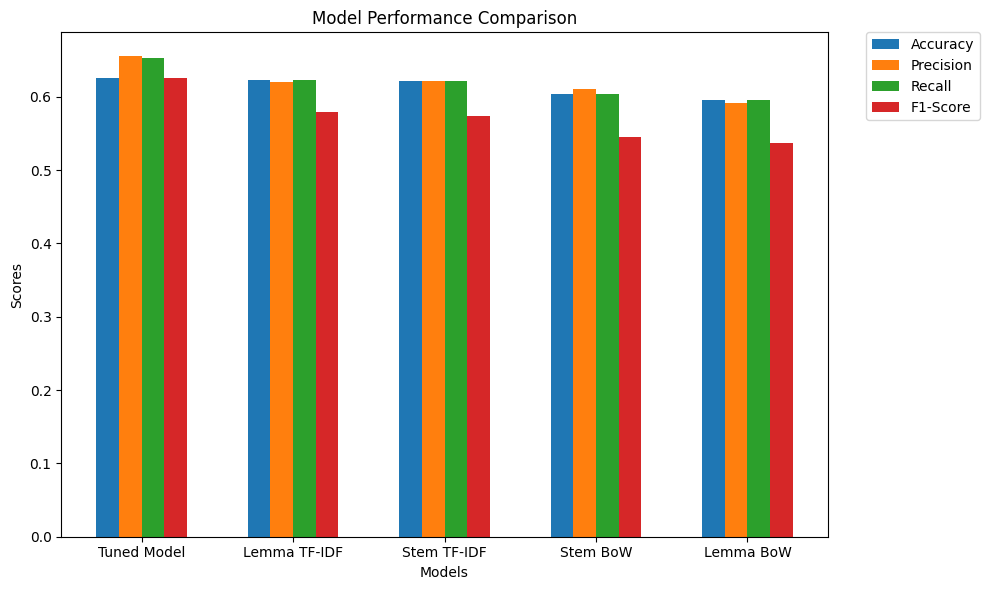

In [73]:
# Plot grouped barchart for performance metrics
calculate_metrics_viz(X_val, y_val, y_pred_lemma_bow_knn, y_pred_lemma_tfidf_knn, y_pred_stem_bow_knn, y_pred_stem_tfidf_knn,
                 y_pred_knn_tuned, knn_lemma_bow, knn_lemma_tfidf, knn_stem_bow, knn_stem_tfidf, grid_search_knn)

- Building an ensemble model like the Random Forest Classifier is necessary because it combines the predictions of multiple decision trees, reducing the risk of overfitting and improving generalization. 
- Random Forests can capture complex, non-linear relationships in the data and are robust to noise and outliers. 
- Unlike the Multinomial Naive Bayes classifier, which assumes feature independence, and KNN, which can be sensitive to irrelevant features and data scaling, Random Forests can automatically handle feature interactions and provide feature importance scores. 
- Thus, ensemble models are well-suited for high-dimensional, noisy text data and typically perform single-model approaches such as KNN and MNB Classifiers.

### 4.2.5  Random Forest Classifier
- Ensemble models such as **Random Forest** combine the predictions of multiple decision trees, reducing the risk of overfitting and improving generalization. 
- Random Forests can capture complex, non-linear relationships in the data and are robust to noise and outliers.
- Ensemble models are well-suited for high-dimensional, noisy text data and typically perform single-model approaches such as KNN and MNB Classifiers.

In [74]:
rf_lemma_bow = Pipeline([
        ('clean', FunctionTransformer(lambda x: [clean_text(t) for t in x], validate=False)),  # Clean text
        ('stopwords', FunctionTransformer(lambda x: [remove_stopwords(t) for t in x], validate=False)),  # Remove stopwords
        ('lemmatize', FunctionTransformer(lambda x: [lemmatize_text(t) for t in x], validate=False)),  # Lemmatize
        ('vectorize', CountVectorizer()),  # BoW vectorization
        ('model', RandomForestClassifier(random_state=42)) 
    ])

In [75]:
rf_lemma_tfidf = Pipeline([
        ('clean', FunctionTransformer(lambda x: [clean_text(t) for t in x], validate=False)),  # Clean text
        ('stopwords', FunctionTransformer(lambda x: [remove_stopwords(t) for t in x], validate=False)),  # Remove stopwords
        ('lemmatize', FunctionTransformer(lambda x: [lemmatize_text(t) for t in x], validate=False)),  # Lemmatize
        ('vectorize', TfidfVectorizer()),  # TF-IDF vectorization
        ('model', RandomForestClassifier(random_state=42)) 
    ])

In [76]:
rf_stem_bow = Pipeline([
        ('clean', FunctionTransformer(lambda x: [clean_text(t) for t in x], validate=False)), # Clean text
        ('stopwords', FunctionTransformer(lambda x: [remove_stopwords(t) for t in x], validate=False)), # Remove stopwords
        ('stem', FunctionTransformer(lambda x: [stem_text(t) for t in x], validate=False)), # Stemmize
        ('vectorize', CountVectorizer()),# BoW vectorization
        ('model', RandomForestClassifier(random_state=42))  
    ])

In [77]:
rf_stem_tfidf = Pipeline([
        ('clean', FunctionTransformer(lambda x: [clean_text(t) for t in x], validate=False)), # Clean text
        ('stopwords', FunctionTransformer(lambda x: [remove_stopwords(t) for t in x], validate=False)), # Remove stopwords
        ('stem', FunctionTransformer(lambda x: [stem_text(t) for t in x], validate=False)), # Stemmize
        ('vectorize', TfidfVectorizer()),# TF-IDF vectorization
        ('model', RandomForestClassifier(random_state=42))  
])

In [78]:
# Fit Vanilla MNB models on training set
rf_lemma_bow.fit(X_train, y_train)
rf_lemma_tfidf.fit(X_train, y_train)
rf_stem_bow.fit(X_train, y_train)
rf_stem_tfidf.fit(X_train, y_train)

# Predict labels for validation set
y_pred_lemma_bow_rf = rf_lemma_bow.predict(X_val)
y_pred_lemma_tfidf_rf = rf_lemma_tfidf.predict(X_val)
y_pred_stem_bow_rf = rf_stem_bow.predict(X_val)
y_pred_stem_tfidf_rf = rf_stem_tfidf.predict(X_val)

In [79]:
# Calculate performance metrics to select model for hyperparameter tuning
calculate_metrics(X_val, y_val, y_pred_lemma_bow_rf, y_pred_lemma_tfidf_rf, y_pred_stem_bow_rf, y_pred_stem_tfidf_rf,
                 rf_lemma_bow, rf_lemma_tfidf, rf_stem_bow, rf_stem_tfidf)

,Accuracy,Precision,Recall,F1-Score
Lemma BoW,0.664363,0.665387,0.664363,0.642852
Lemma TF-IDF,0.671275,0.676063,0.671275,0.648499
Stem BoW,0.671275,0.670318,0.671275,0.649926
Stem TF-IDF,0.666667,0.666692,0.666667,0.644874


Both Lemma TF-IDF and Stem BoW tie for the highest Accuracy and Recall, with Stem BoW having a marginally higher F1-Score (0.6499 vs. 0.6485). Given the imbalanced dataset, the slight edge in F1-Score for **Stem BoW** makes it a slightly better candidate, as it indicates a better balance between precision and recall. This model is likely to benefit from hyperparameter tuning to further optimize its performance across all sentiment classes.

- Hence, the vanilla **Random Forest Classifier** fitted with **_Stemmed_** data that is vectorized via the **_BOW_** technique (**rf_stem_bow**) is selected for Hyper-parameter tuning.
- The scoring parameter for GridSearchCV is set to **'f1_weighted'** to prioritize improving the model's ability to classify all sentiments accurately, especially the minority classes.

In [80]:
# Hyperparameter tuning for rf_stem_bow using GridSearchCV
from sklearn.model_selection import GridSearchCV

def clean_texts(texts):
    return [clean_text(t) for t in texts]
def remove_stopwords_texts(texts):
    return [remove_stopwords(t) for t in texts]
def stem_texts(texts):
    return [stem_text(t) for t in texts]

rf_stem_bow_pipeline = Pipeline([
    ('clean', FunctionTransformer(clean_texts, validate=False)),
    ('stopwords', FunctionTransformer(remove_stopwords_texts, validate=False)),
    ('stem', FunctionTransformer(stem_texts, validate=False)),
    ('vectorize_rf', CountVectorizer()),
    ('model', RandomForestClassifier(random_state=42))
])

param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__bootstrap': [True, False],
    'vectorize_rf__max_features': [2000, 5000, 10000], 
    'vectorize_rf__ngram_range': [(1, 1), (1, 2), (1, 3)] 
}

grid_search_rf = GridSearchCV(rf_stem_bow_pipeline, param_grid, cv=5, scoring='f1_weighted', n_jobs=1)
grid_search_rf.fit(X_train, y_train)

print("Best parameters:", grid_search_rf.best_params_)
print("Best cross-validated accuracy:", grid_search_rf.best_score_)


Best parameters: {'model__bootstrap': True, 'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 200, 'vectorize_rf__max_features': 2000, 'vectorize_rf__ngram_range': (1, 1)}
Best cross-validated accuracy: 0.6365542320521692


In [81]:
# Print classification report and confusion matrix of selected vanilla model for tuning
classification_metrics(y_val, y_pred_stem_bow_rf)

Classification Report
              precision    recall  f1-score   support

    Negative       0.68      0.23      0.34        91
     Neutral       0.67      0.86      0.76       742
    Positive       0.66      0.46      0.54       469

    accuracy                           0.67      1302
   macro avg       0.67      0.52      0.55      1302
weighted avg       0.67      0.67      0.65      1302

Confusion Matrix
[[ 21  56  14]
 [  9 638  95]
 [  1 253 215]]


In [82]:
# Print classification report and confusion matrix of tuned model
y_pred_rf_tuned = grid_search_rf.predict(X_val)
classification_metrics(y_val, y_pred_rf_tuned)

Classification Report
              precision    recall  f1-score   support

    Negative       0.78      0.20      0.32        91
     Neutral       0.68      0.87      0.76       742
    Positive       0.66      0.48      0.56       469

    accuracy                           0.68      1302
   macro avg       0.71      0.51      0.55      1302
weighted avg       0.68      0.68      0.66      1302

Confusion Matrix
[[ 18  56  17]
 [  3 642  97]
 [  2 241 226]]


In [83]:
# Compute accuracy, precision, recall, and f1-score
df_metrics_compare_rf = calculate_metrics_compare(X_val, y_val, y_pred_lemma_bow, y_pred_lemma_tfidf, y_pred_stem_bow, y_pred_stem_tfidf,
                     y_pred_rf_tuned, rf_lemma_bow, rf_lemma_tfidf, rf_stem_bow, rf_stem_tfidf, grid_search_rf)

# Slice the DataFrame to include the selected vanilla model and the tuned classifier
df_filtered_rf = df_metrics_compare_rf.loc[['Stem BoW', 'Tuned Model']]

# Display the filtered results
df_filtered_rf

,Accuracy,Precision,Recall,F1-Score
Stem BoW,0.671275,0.646639,0.655146,0.639883
Tuned Model,0.658630,0.683774,0.680492,0.658630


The tuned Random Forest Classifier achieved an accuracy of 0.6843, improving upon the untuned model's accuracy of 0.6697. 
- This improvement is primarily due to the optimization of key hyperparameters such as the number of trees (`n_estimators`), tree depth (`max_depth`), and minimum samples required for splits and leaves. 
- By systematically searching for the best combination of these parameters, the model is better able to capture relevant patterns in the data and avoid both underfitting and overfitting, leading to enhanced predictive performance.

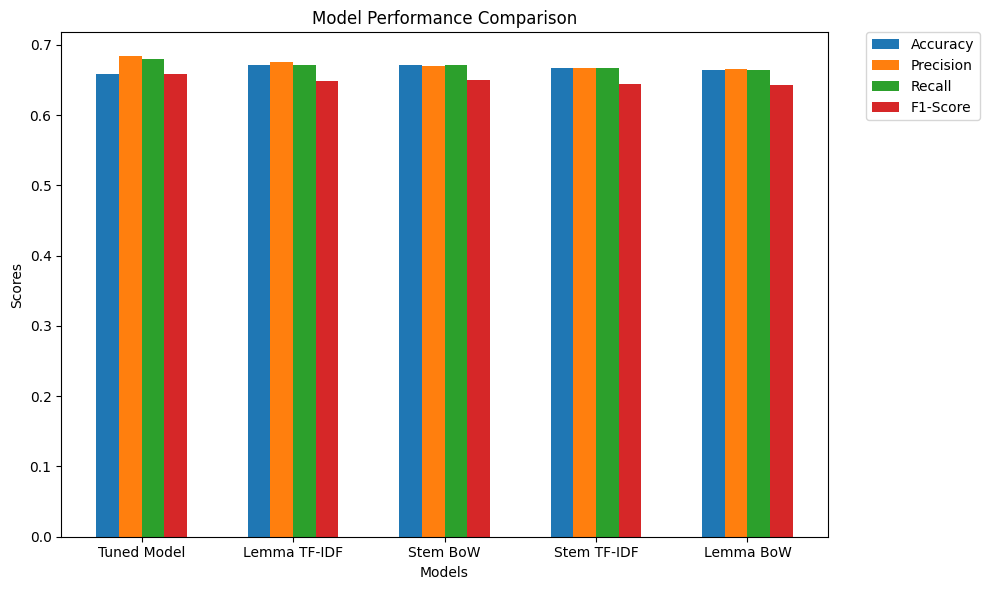

In [84]:
# Plot grouped barchart for performance metrics
calculate_metrics_viz(X_val, y_val, y_pred_lemma_bow_rf, y_pred_lemma_tfidf_rf, y_pred_stem_bow_rf, y_pred_stem_tfidf_rf,
                 y_pred_rf_tuned, rf_lemma_bow, rf_lemma_tfidf, rf_stem_bow, rf_stem_tfidf, grid_search_rf)

Despite these gains, Random Forest Classifiers have inherent limitations. 
- They can become computationally expensive with large datasets or a high number of trees, and their predictions may lack interpretability due to the ensemble nature of the model. 
- Additionally, Random Forests may struggle to capture complex, high-level abstractions or sequential dependencies in text data, as they rely on bag-of-words or similar feature representations that ignore word order and context.

### 4.2.6 Neural Network

Building a neural network model, such as a deep learning architecture, offers the potential for further improvement. 
- Implementing a simple feedforward neural network (Multi-Layer Perceptron) for sentiment classification using Keras. 
- The pipeline encapsulates text cleaning, stopwords removal, lemmatization, TF-IDF vectorization, and a sequential neural network model. 
- The pipeline justifies conformity to the preprocessing workflow and guarantees consistency.TfidfVectorizer

In [216]:
# Preprocess data: clean, remove stopwords, pos-lemmatize, TF-IDF vectorize
def preprocess_texts(texts):
    return [pos_lemmatize_text(tweet_tokenize_text(remove_stopwords(clean_text(t)))) for t in texts]

X_train_nn = preprocess_texts(X_train)
X_val_nn = preprocess_texts(X_val)
X_test_nn = preprocess_texts(X_test)

# TF-IDF vectorization
tfidf_vectorizer_nn = TfidfVectorizer()
X_train_vec = tfidf_vectorizer_nn.fit_transform(X_train_nn).toarray()
X_val_vec = tfidf_vectorizer_nn.transform(X_val_nn).toarray()
X_test_vec = tfidf_vectorizer_nn.transform(X_test_nn).toarray()

# Encode labels
label_encoder = LabelEncoder()
y_train_enc = to_categorical(label_encoder.fit_transform(y_train))
y_val_enc = to_categorical(label_encoder.transform(y_val))
y_test_enc = to_categorical(label_encoder.transform(y_test))

In [217]:
# Build the model
neural_network = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_vec.shape[1],)),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(8, activation='relu'),
    Dropout(0.1),
    Dense(y_train_enc.shape[1], activation='softmax')
])

neural_network.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [218]:
# Train the model
history = neural_network.fit(
    X_train_vec, y_train_enc,
    validation_data=(X_val_vec, y_val_enc),
    epochs=10,
    batch_size=32,
    verbose=1
)

# Evaluate on validation set
val_loss, val_acc = neural_network.evaluate(X_val_vec, y_val_enc, verbose=0)
print(f"Validation accuracy: {val_acc:.4f}")

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5573 - loss: 0.9914 - val_accuracy: 0.5914 - val_loss: 0.8231
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6390 - loss: 0.7747 - val_accuracy: 0.6551 - val_loss: 0.7685
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7393 - loss: 0.6305 - val_accuracy: 0.6498 - val_loss: 0.7746
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8022 - loss: 0.4946 - val_accuracy: 0.6444 - val_loss: 0.8320
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8393 - loss: 0.4077 - val_accuracy: 0.6382 - val_loss: 0.9124
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8833 - loss: 0.3419 - val_accuracy: 0.6329 - val_loss: 0.9667
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8985 - loss: 0.2809 - val_accuracy: 0.6490 - val_loss: 1.0772
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9087 - loss: 0.2461 - val_accuracy: 0.

In [219]:
neural_network.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 32)             │       202,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 610,907 (2.33 MB)

 Trainable params: 203,635 (795.45 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 407,272 (1.55 MB)

After trying multiple configurations of the hidden **_Dense Layers_**, the neural network model (Multi-Layer Perceptron) plateaued at a validation accuracy of 0.6429. Possible limitations of the neural network model could be attributed to:

- **Feature Representation**: The model relies on vectorized text features, which could be limiting the neural network in capturing word order or contextual relationships, potentially limiting its ability to understand nuanced sentiment.
- **Model Complexity**: The architecture is relatively simple, consisting of only a few dense layers. This may restrict its capacity to model complex patterns in the data.
- **Overfitting/Underfitting**: Without careful tuning, the model may overfit (memorize training data) or underfit (fail to learn enough), especially given the fixed dropout rates and layer sizes.
- **Hyperparameter Sensitivity**: Neural networks are highly sensitive to hyperparameters such as learning rate, batch size, number of layers, number of neurons, activation functions, and dropout rates.

The neural network model can be improved by leveraging pretrained NLP models such as **BERT**. However, transfer learning is beyond the scope of this project's objectives.  

## 5 Model Performance Comparison on Test Set

- The tuned models' performance is compared on the test set.
- The best performing model is pickled using joblib.



In [220]:
# Compute test set accuracy for each tuned model
test_score_nb = grid_search.score(X_test, y_test)
test_score_knn = grid_search_knn.score(X_test, y_test)
test_score_rf = grid_search_rf.score(X_test, y_test)
test_loss_nn, test_score_nn = neural_network.evaluate(X_test_vec, y_test_enc, verbose=0)

# Format results in a DataFrame
results_df = pd.DataFrame({
    'Model': ['Tuned MultinomialNB', 'Tuned KNN', 'Tuned RandomForest', 'Neural Network'],
    'Test_Accuracy': [test_score_nb, test_score_knn, test_score_rf, test_score_nn]
})

# Compute precision, recall, and f1-score for each model
from sklearn.metrics import precision_score, recall_score, f1_score

# Predict labels for each model
y_pred_nb = grid_search.predict(X_test)
y_pred_knn = grid_search_knn.predict(X_test)
y_pred_rf = grid_search_rf.predict(X_test)
y_pred_nn = (neural_network.predict(X_test_vec) > 0.5).astype(int)  # Prediction threshold for neural network

# Add precision, recall, and f1-score to the DataFrame
results_df['Test_Precision'] = [precision_score(y_test, y_pred_nb, average='weighted'),
                               precision_score(y_test, y_pred_knn, average='weighted'),
                               precision_score(y_test, y_pred_rf, average='weighted'),
                               precision_score(y_test_enc, y_pred_nn, average='weighted')]
results_df['Test_Recall'] = [recall_score(y_test, y_pred_nb, average='weighted'),
                            recall_score(y_test, y_pred_knn, average='weighted'),
                            recall_score(y_test, y_pred_rf, average='weighted'),
                            recall_score(y_test_enc, y_pred_nn, average='weighted')]
results_df['Test_F1'] = [f1_score(y_test, y_pred_nb, average='weighted'),
                        f1_score(y_test, y_pred_knn, average='weighted'),
                        f1_score(y_test, y_pred_rf, average='weighted'),
                        f1_score(y_test_enc, y_pred_nn, average='weighted')]
results_df

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


,Model,Test_Accuracy,Test_Precision,Test_Recall,Test_F1
0,Tuned MultinomialNB,0.656232,0.655598,0.662776,0.656232
1,Tuned KNN,0.602126,0.637935,0.636978,0.602126
2,Tuned RandomForest,0.663244,0.689657,0.685504,0.663244
3,Neural Network,0.664619,0.661348,0.660934,0.657428


- Visualize performance metrics

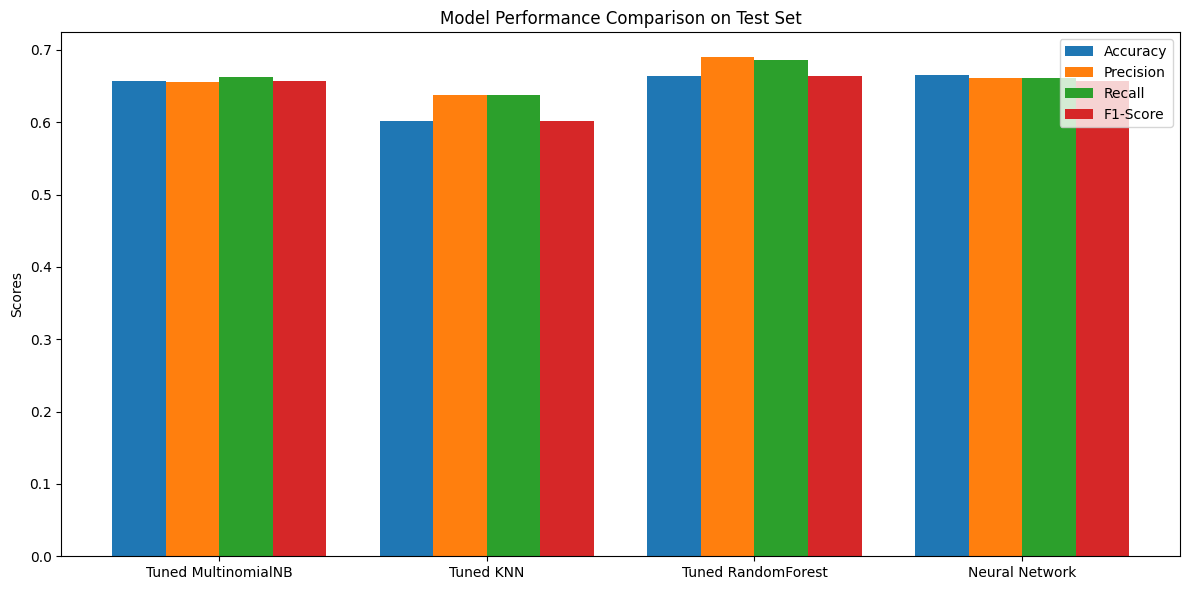

In [221]:
# Plotting the results

models = results_df['Model']
x = np.arange(len(models))
width = 0.2

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width*1.5, results_df['Test_Accuracy'], width, label='Accuracy')
rects2 = ax.bar(x - width/2, results_df['Test_Precision'], width, label='Precision')
rects3 = ax.bar(x + width/2, results_df['Test_Recall'], width, label='Recall')
rects4 = ax.bar(x + width*1.5, results_df['Test_F1'], width, label='F1-Score')

ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison on Test Set')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=0)
ax.legend()

plt.tight_layout()
plt.show()

- plot confusion matrices

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


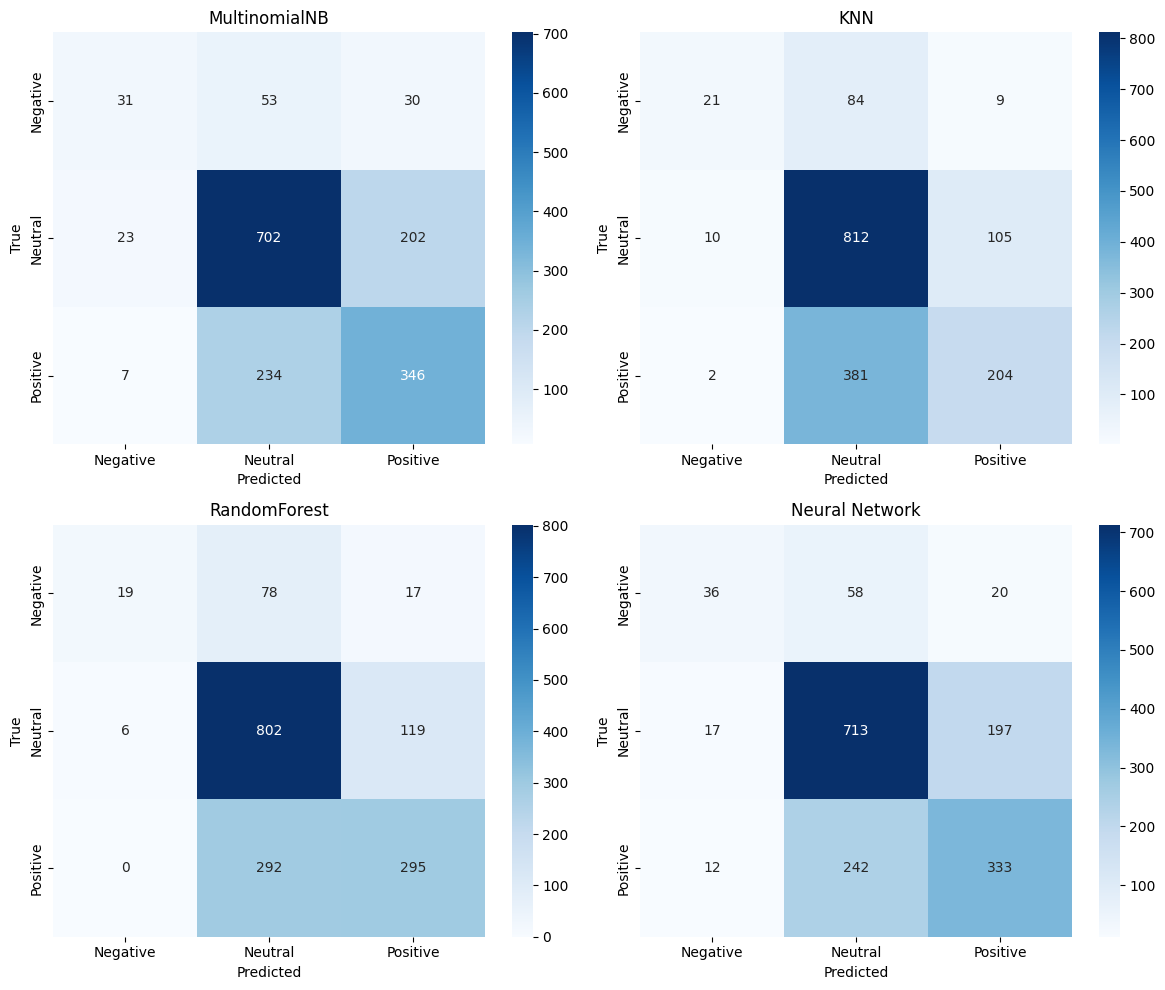

In [222]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder  

le = LabelEncoder()  
le.fit(y_train) 
label_names = le.classes_ 

# Get predictions for each model
y_pred_mnb = grid_search.predict(X_test)
y_pred_knn = grid_search_knn.predict(X_test)
y_pred_rf = grid_search_rf.predict(X_test)
y_pred_nn = np.argmax(neural_network.predict(X_test_vec), axis=1)  # Use argmax for multiclass

# Compute confusion matrices
cm_mnb = confusion_matrix(y_test, y_pred_mnb)
cm_knn = confusion_matrix(y_test, y_pred_knn)
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_nn = confusion_matrix(np.argmax(y_test_enc, axis=1), y_pred_nn)  # Both now in single-label format

# Set up the 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot confusion matrix for MultinomialNB
sns.heatmap(cm_mnb, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0], xticklabels=label_names, yticklabels=label_names)
axes[0, 0].set_title('MultinomialNB')
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_ylabel('True')

# Plot confusion matrix for KNN
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', ax=axes[0, 1], xticklabels=label_names, yticklabels=label_names)
axes[0, 1].set_title('KNN')
axes[0, 1].set_xlabel('Predicted')
axes[0, 1].set_ylabel('True')

# Plot confusion matrix for RandomForest
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0], xticklabels=label_names, yticklabels=label_names)
axes[1, 0].set_title('RandomForest')
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('True')

# Plot confusion matrix for Neural Network
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1], xticklabels=label_names, yticklabels=label_names)
axes[1, 1].set_title('Neural Network')
axes[1, 1].set_xlabel('Predicted')
axes[1, 1].set_ylabel('True')

# Insert vertical and horizontal spacing between subplots
plt.subplots_adjust(hspace=0.4, wspace=0.2) 

plt.tight_layout()
plt.show()

- The tuned Random Forest Classifier is the best model according to the test set accuracy reported in results_df. The model outperforms the tuned Multinomial Naive Bayes, KNN, and Neural Network models. 
- The Random Forest's superior performance can be attributed to its ensemble approach, which combines multiple decision trees to reduce overfitting and capture complex, non-linear relationships in the data. 
- Additionally, Random Forests are robust to noise and can handle high-dimensional feature spaces, making them well-suited for text classification tasks.

Hence, the tuned Random Forest Classifier is selected for deployment because it achieves the highest accuracy on unseen data, indicating strong generalization capability. It strikes and effective balance on predictive power, robustness, and interpretability makes the tuned Random Forest Classifier the optimal choice for deployment in this sentiment analysis pipeline. Furthermore, Random Forests provide feature importance scores, aiding interpretability, and are less sensitive to hyperparameter choices compared to neural networks. 


The best parameters for the **Tuned Random Forest Classifier were as follows:**
- **text normalization** : **_Stemming_**
- **bootstrap** : **_True_**
- **max_depth** : **_None_**
- **min_samples_leaf** : **_1_**
- **min_samples_split** : **_5_**
- **n_estimators** : **_200_**
- **CountVectorizer** : **_(max_features=2000, ngram_range = (1, 1))_**

In [213]:
def clean_texts(texts):
    return [clean_text(t) for t in texts]
def remove_stopwords_texts(texts):
    return [remove_stopwords(t) for t in texts]
def stem_texts(texts):
    return [stem_text(t) for t in texts]

# Define the tuned RandomForestClassifier
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=1,
    bootstrap=True,
    random_state=42
)

# Build the pipeline
rf_pipeline = Pipeline([
    ('clean', FunctionTransformer(clean_texts, validate=False)),
    ('stopwords', FunctionTransformer(remove_stopwords_texts, validate=False)),
    ('stem', FunctionTransformer(stem_texts, validate=False)),
    ("vectorize_rf", CountVectorizer(max_features=2000, ngram_range=(1, 1))),
    ("model", rf_model)
])

# Fit the model (use your data variables here)
rf_pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf_pipeline.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

    Negative       0.76      0.17      0.27       114
     Neutral       0.68      0.87      0.76       927
    Positive       0.68      0.50      0.58       587

    accuracy                           0.69      1628
   macro avg       0.71      0.51      0.54      1628
weighted avg       0.69      0.69      0.66      1628

Confusion Matrix:
[[ 19  78  17]
 [  6 802 119]
 [  0 292 295]]


In [214]:
# Save best performing model for sentiment prediction
#from preprocessing import clean_texts
import joblib

joblib.dump(rf_pipeline, "randomforest_model.joblib")
print("Random Forest Classifier model for predicting `sentiment` (Negative, Neutral or Positive) saved as 'randomforest_model.joblib'")

Random Forest Classifier model for predicting `sentiment` (Negative, Neutral or Positive) saved as 'randomforest_model.joblib'


In [226]:
# Save the neural network model
neural_network.save('neural_network.keras')

# Save the neural network model's vectorizer
joblib.dump(tfidf_vectorizer_nn, "tfidf_vectorizer.joblib")

['tfidf_vectorizer.joblib']

## 6 Model Interpretabilty

- Since Random Forests are black box models, this section utilizes the LIME library to interpret the tuned_random_forest_classifier.

In [177]:
import lime.lime_tabular

# Prepare cleaned training data (vectorized form)
X_train_cleaned = [" ".join(x) if isinstance(x, list) else x for x in X_train]
X_test_cleaned = [" ".join(x) if isinstance(x, list) else x for x in X_test]

vectorizer = rf_pipeline.named_steps["vectorize_rf"]
model = rf_pipeline.named_steps["model"]

X_train_vec = vectorizer.transform(X_train_cleaned).toarray()
X_test_vec = vectorizer.transform(X_test_cleaned).toarray()

# Get feature names
feature_names = vectorizer.get_feature_names_out()

# Initialize LimeTabularExplainer
explainer_tabular = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_vec,
    feature_names=feature_names,
    class_names=np.unique(y_train),
    mode="classification"
)

In [188]:
# Choose an instance to explain
instance_index = 1050
instance_vec = X_test_vec[instance_index]

# Define predict function (model only)
predict_fn_tabular = model.predict_proba

# Explain selected instance
exp_tabular = explainer_tabular.explain_instance(
    data_row=instance_vec,
    predict_fn=predict_fn_tabular,
    num_features=15
)

# Visualize
# exp_tabular.show_in_notebook()
# print(exp_tabular.as_list())
exp_tabular.save_to_file("lime_tabular_explanation.html")

- The explanations for the prediction made by the **tuned random forest classifier** for the test set **_instance_index = 1600_** (**neutral sentiment prediction**) are captured in the image below. 

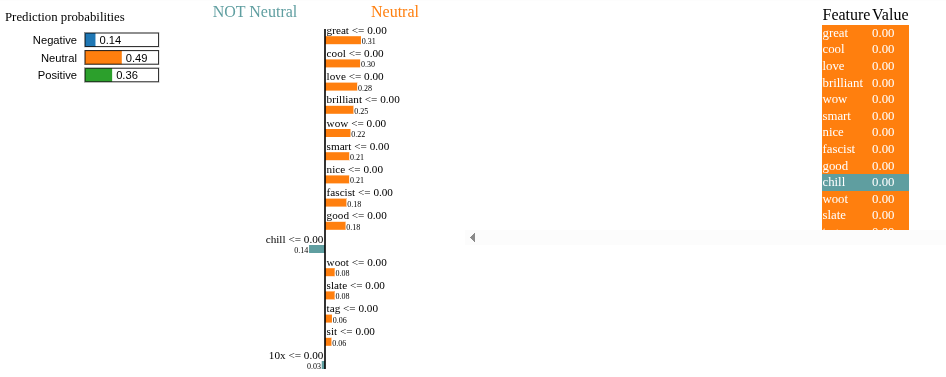

- The explanations for the prediction made by the **tuned random forest classifier** for the test set **_instance_index = 1030_** (**positive sentiment prediction**) are captured in the image below. 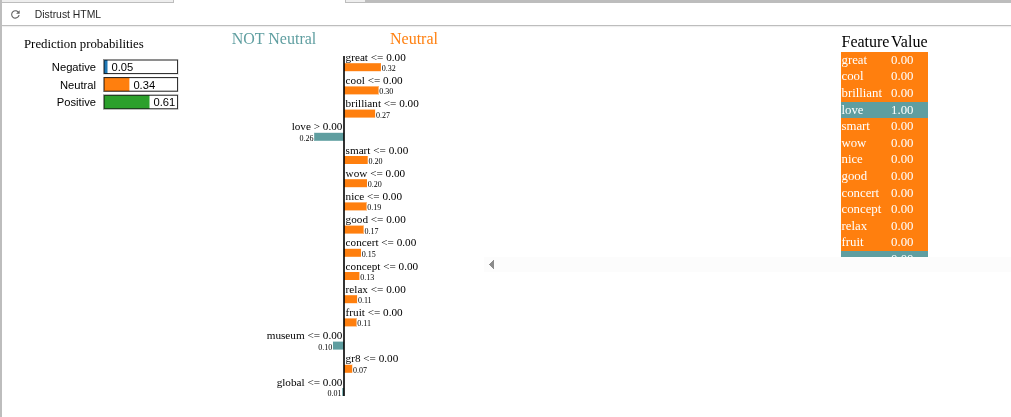



## 7 Deployment

- This NLP project pursues two objectives:
1. To predict `product` (**_Apple_** or **_Google_**) based on `tweet`: Accomplished by the **tuned Logistic Regression model** that is saved via joblib as **_logistic_model.joblib_**
2. To predict `sentiment` (**_Negative_**, **_Neutral_**, or **_Positive_**) based on `tweet`: Accomplished by the **tuned Random Forest model** that is saved via joblib as **_randomforest_model.joblib_**
- Thus; the app created for deployment encapsulates both models to predict a client's `product` and their respective`sentiment` based on tweet content/ context.
- Deployment app created on Streamlit.

### 7.1 LR (Product Predicition) and RF (Sentiment Predicition)

In [ ]:
# Saved as streamlit_app.py

import streamlit as st
import joblib
import numpy as np
from collections import Counter
from wordcloud import WordCloud
import nltk 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer 
from nltk import pos_tag  
import string  
import re 
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model



def clean_texts(texts):
    return [clean_text(t) for t in texts]
def remove_stopwords_texts(texts):
    return [remove_stopwords(t) for t in texts]
def stem_texts(texts):
    return [stem_text(t) for t in texts]
def preprocess_texts(texts):
    return [pos_lemmatize_text(tweet_tokenize_text(remove_stopwords(clean_text(t)))) for t in texts]

# Define function to remove URLs, mentions, hashtags, punctuation, and lowercase
def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
   # text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.lower()
    return text

# Define function to remove stopwords from text
def remove_stopwords(text):
    stop_words = stopwords.words('english')
    pronouns = {'i', 'me', 'my', 'mine', 'myself', 'you', 'your', 'yours', 'yourself',
                'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself',
                'it', 'its', 'itself', 'we', 'us', 'our', 'ours', 'ourselves',
                'they', 'them', 'their', 'theirs', 'themselves'}
    stop_words += pronouns
    tokens = word_tokenize(text)
    return ' '.join([word for word in tokens if word not in stop_words])

# Define function to lemmatize each word in the text
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    return ' '.join([lemmatizer.lemmatize(word) for word in tokens])

# Define function to Stem each word in the text
def stem_text(text):
    stemmer = PorterStemmer()
    tokens = word_tokenize(text)
    return ' '.join([stemmer.stem(word) for word in tokens])

# Define function to lemmatize using POS tagging
# To use Neural Network
def pos_lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    def get_wordnet_pos(tag):
        if tag.startswith('J'):
            return 'a'
        elif tag.startswith('V'):
            return 'v'
        elif tag.startswith('N'):
            return 'n'
        elif tag.startswith('R'):
            return 'r'
        else:
            return 'n'
    return ' '.join([lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags])

# Define function to stem using POS tagging
def pos_stem_text(text):
    stemmer = PorterStemmer()
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    return ' '.join([stemmer.stem(word) for word, _ in pos_tags])

# Define function to tokenize using TweetTokenizer
def tweet_tokenize_text(text):
    tokenizer = TweetTokenizer()
    return ' '.join(tokenizer.tokenize(text))

# Define function to tokenize using word_tokenize
def word_tokenize_text(text):
    return word_tokenize(text)


# Load models
product_model = joblib.load("logistic_model.joblib")
sentiment_model = joblib.load("randomforest_model.joblib")

st.title("Tweet Analyzer: Product & Sentiment Prediction using LR and RF")

tweet = st.text_area("Enter a Tweet:")

if st.button("Predict"):
    if tweet.strip() == "":
        st.warning("Please enter a tweet.")
    else:
        product = product_model.predict([tweet])[0]
        sentiment = sentiment_model.predict([tweet])[0]

        st.subheader("Predictions")
        st.write(f"**Product**: {product}")
        st.write(f"**Sentiment**: {sentiment}")


### 7.2 LR (Product Predicition) and NN (Sentiment Predicition)

In [ ]:
# Saved streamlit_app_nn
import streamlit as st
import joblib
import numpy as np
from tensorflow.keras.models import load_model
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import string
import re

# --- Preprocessing ---
def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#\w+", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = text.lower()
    return text

def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    tokens = word_tokenize(text)
    return ' '.join([word for word in tokens if word not in stop_words])

def pos_lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    def get_wordnet_pos(tag):
        if tag.startswith("J"):
            return "a"
        elif tag.startswith("V"):
            return "v"
        elif tag.startswith("N"):
            return "n"
        elif tag.startswith("R"):
            return "r"
        else:
            return "n"
    return ' '.join([lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags])

def preprocess_text(text):
    text = clean_text(text)
    text = remove_stopwords(text)
    text = pos_lemmatize_text(text)
    return text

# --- Load models ---
product_model = joblib.load("logistic_model.joblib")
vectorizer = joblib.load("tfidf_vectorizer.joblib")
sentiment_model = load_model("neural_network.keras")

# --- Streamlit App ---
st.title("Tweet Classifier: Product & Sentiment using LR and NN")

tweet = st.text_area("Enter a tweet below:")

if st.button("Predict"):
    if not tweet.strip():
        st.warning("Please enter a tweet.")
    else:
        # Predict product directly using pipeline
        product = product_model.predict([tweet])[0]

        # Preprocess for sentiment prediction
        cleaned = preprocess_text(tweet)
        vectorized = vectorizer.transform([cleaned]).toarray()

        # Predict sentiment
        sentiment_probs = sentiment_model.predict(vectorized)
        sentiment_label = np.argmax(sentiment_probs, axis=1)[0]
        sentiment_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
        sentiment = sentiment_map[sentiment_label]

        st.subheader("Predictions:")
        st.write(f"**Product**: {product}")
        st.write(f"**Sentiment**: {sentiment}")


## 8 Conclusion and Recommendations
### 8.1 Conclusion
- The project applies Natural Language Processing (NLP) to extract insights from tweets relating to Apple and Google.
- The project's scope is bounded to two objectives:
1. To predict whether a tweet refers to an **Apple** or **Google** product: This bjective is achieved by developing and tuning a **Logistic Regression Classifier**.
2. To predict assess the sentiment of a tweet as **Negative**, **Neutral**, or **Positive**: This objective is achieved by developing and tuning a **Multinomial Naive Bayes Classifier**, a **K-Nearest Neighbour Classifier**, a **Random Forest Classifier**, and a **Sequential Neural Network**. The respective performance of the tuned versions of these four classifiers is compared to select the best model for deployment. Based on the finding's (**_Accuracy, Precision, Recall, F1-score_**) and visualizations (**_Confusion Matrices_**); the **tuned Random Forest** model outperforms the other classifiers and it is selected for deployment.  

- The **_tuned Logistic Regression model_** and the **_tuned Random Forest Classifier_** are integrated into a deployment-ready app (**_streamlit_app.py_**) via **Streamlit**.
- The **_tuned Logistic Regression model_** and the **_Sequential Neural Network_** are integrated into a deployment-ready app (**_streamlit_app_nn.py_**) via **Streamlit**.

### 8.2 Recommendations
1. Incorporate a larger and more diverse dataset to reduce potential overfitting, optimize real-world robustness, and enhance generalizability with noisy social media text data.
2. Implement continous model monitoring by integrating real-time feedback loops to support progressive improvement post-deployment.
3. Supplement sentiment and product classification with topic modeling to uncover specific themes or product features being discussed in scrapped tweet data.

## 9 Next Steps

- Deploy the FastAPI backend to a Cloud Service.
- Incorporate real-time Tweet streaming via the X API to stream tweets filtered by keywords.
- Build a Tableau Dashboard to sentiment and product trends in realtime to support data informed decisions.
- Experiment on Transfer Learning by leveraging pretrained transformers on NLP such as BERT.
- Retrain the deployed models with latest tweets data to promote progressive accuracy improvement/ advancements. 